# SL4HOI: Supervised Learning for Predicting Health Opportunity Index across States
### Paper Reproduction Code Presented by Zhiyuan Song, Zihan Mei, Liran Li, and N. Rich Nguyen
![Virginia](https://opportunitynation.org/wp-content/uploads/2014/04/Opportunity-Index-2013-Screenshot.png)

In [ ]:
! git clone https://github.com/LiranLizqj6pe/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States.git

Cloning into 'SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 36 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (36/36), 7.41 MiB | 4.50 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
! pip install geopandas

In [ ]:
import pandas as pd

## New DataSet

In [ ]:
# Load the datasets
hoi_new = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/HOI_new.csv')
health_opportunity_index = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/Health_Opportunity_Index.csv')

In [ ]:
# Find the number of entries in the dataset
print(f"The dataset have {hoi_new.shape[0]} entries (rows)")

The dataset have 1908 entries (rows)


In [ ]:
# Find the number of features in the dataset
print(f"The dataset have {hoi_new.shape[1]} features (columns)")

The dataset have 268 features (columns)


In [ ]:
# Step 1: Extract the number after "US" from the "Geographic Identifier" in HOI_new.csv
hoi_new['Census Tract Match'] = hoi_new['Geographic Identifier'].str.extract(r'US(\d+)')

# Step 2: Perform the merge again using this newly extracted identifier against the "Census Tract" in Health_Opportunity_Index.csv
# Note: Ensure both columns are of the same data type for the merge
hoi_new['Census Tract Match'] = hoi_new['Census Tract Match'].astype(str)
health_opportunity_index['Census Tract'] = health_opportunity_index['Census Tract'].astype(str)

hoi_new_aligned = pd.merge(health_opportunity_index[['Census Tract']], hoi_new, left_on='Census Tract', right_on='Census Tract Match', how='inner')

# Step 3: Drop any empty columns and perform additional necessary cleaning
hoi_new_cleaned = hoi_new_aligned.dropna(axis=1, how='all')

# Removing the additional match column after verification
hoi_new_final = hoi_new_cleaned.drop(columns=['Census Tract Match'])

# Step 4: Verify the alignment and row count
final_row_count = hoi_new_final.shape[0]

# Since the final dataset from the previous step already includes the Census Tract alignment, we'll directly merge the HOI values
hoi_new_final_with_hoi = pd.merge(hoi_new_final, health_opportunity_index[['Census Tract', 'Health Opportunity Index']], left_on='Census Tract_x', right_on='Census Tract', how='left')

# Drop the duplicate Census Tract column from the merge operation
hoi_new_final_with_hoi.drop(columns=['Census Tract'], inplace=True)

# Drop the specified "rubbish" columns from the final dataset
columns_to_drop = [
    "FIPS", "Area Name","State/U.S.-Abbreviation (USPS)", "State/U.S.-Abbreviation (USPS)", "File Identification", "Qualifying Name", "State Postal Abbreviation",
    "Summary Level", "Geographic Component", "File identification",
    "Logical Record Number", "State (FIPS Code)", "County of current residence",
    "Census Tract_y", "Geographic Identifier", "Total Population.1"
]
# Drop these columns, being careful to only drop those that exist in the dataframe to avoid KeyError
hoi_new_final_cleaned = hoi_new_final_with_hoi.drop(columns=[col for col in columns_to_drop if col in hoi_new_final_with_hoi.columns])

hoi_new_final_cleaned.to_csv("HOI_new_cleaned.csv", index = False)


# Combine several columns to simplify data
def sum_attr(row, col_names):
  sum = 0
  for col_name in col_names:
    sum += float(row[col_name])
  return sum


hoi_new_final_cleaned['% Households: Less than $30,000'] = hoi_new_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: Less than $10,000", "% Households: $10,000 to $14,999",
     "% Households: $15,000 to $19,999", "% Households: $20,000 to $24,999",
     "% Households: $25,000 to $29,999"]
  ), axis=1)

hoi_new_final_cleaned['% Households: $30,000 to $99,999'] = hoi_new_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: $30,000 to $34,999", "% Households: $35,000 to $39,999",
     "% Households: $40,000 to $44,999", "% Households: $45,000 to $49,999",
     "% Households: $50,000 to $59,999", "% Households: $60,000 to $74,999",
     "% Households: $75,000 to $99,999"]
  ), axis=1)


hoi_new_final_cleaned['% Households: $100,000 or More'] = hoi_new_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: $100,000 to $124,999", "% Households: $125,000 to $149,999",
     "% Households: $150,000 to $199,999", "% Households: $200,000 or More"]
  ), axis=1)

hoi_new_final_cleaned['% Renter-Occupied Housing Units: Less than $1,000'] = hoi_new_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Renter-Occupied Housing Units: Less than $300", "% Renter-Occupied Housing Units: $300 to $499",
     "% Renter-Occupied Housing Units: $500 to $799", "% Renter-Occupied Housing Units: $800 to $999"]
  ), axis=1)


hoi_new_final_cleaned['% Renter-Occupied Housing Units: $1,000 to $2,499'] = hoi_new_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Renter-Occupied Housing Units: $1,000 to $1,499", "% Renter-Occupied Housing Units: $1,500 to $1,999",
     "% Renter-Occupied Housing Units: $2,000 to $2,499", "% Renter-Occupied Housing Units: $2,500 to $2,999"]
  ), axis=1)

columns_to_drop_after_aggregation = [
    "Households: Less than $10,000",
    "Households: $10,000 to $14,999",
    "Households: $15,000 to $19,999",
    "Households: $20,000 to $24,999",
    "Households: $25,000 to $29,999",
    "Households: $30,000 to $34,999",
    "Households: $35,000 to $39,999",
    "Households: $40,000 to $44,999",
    "Households: $45,000 to $49,999",
    "Households: $50,000 to $59,999",
    "Households: $60,000 to $74,999",
    "Households: $75,000 to $99,999",
    "Households: $100,000 to $124,999",
    "Households: $125,000 to $149,999",
    "Households: $150,000 to $199,999",
    "Households: $200,000 or More",
    "Renter-Occupied Housing Units: Less than $300",
    "Renter-Occupied Housing Units: $300 to $499",
    "Renter-Occupied Housing Units: $500 to $799",
    "Renter-Occupied Housing Units: $800 to $999",
    "Renter-Occupied Housing Units: $1,000 to $1,499",
    "Renter-Occupied Housing Units: $1,500 to $1,999",
    "Renter-Occupied Housing Units: $2,000 to $2,499",
    "Renter-Occupied Housing Units: $2,500 to $2,999",
]

hoi_new_final_cleaned_merged = hoi_new_final_cleaned.drop(columns=[col for col in columns_to_drop_after_aggregation if col in hoi_new_final_cleaned.columns])


# Specify additional columns to drop based on the extended list provided
columns_to_drop_extended = [
    "Area (Land).1",
    "Renter-Occupied Housing Units: Householder 15 to 24 Years",
    "Renter-Occupied Housing Units: Householder 25 to 34 Years",
    "Renter-Occupied Housing Units: Householder 35 to 44 Years",
    "Renter-Occupied Housing Units: Householder 45 to 54 Years",
    "Renter-Occupied Housing Units: Householder 55 to 59 Years",
    "Renter-Occupied Housing Units: Householder 60 to 64 Years",
    "Renter-Occupied Housing Units: Householder 65 to 74 Years",
    "Renter-Occupied Housing Units: Householder 75 to 84 Years",
    "Renter-Occupied Housing Units: Householder 85 Years and Over",
    "Population 3 Years and Over: Enrolled in School",
    "Population 3 Years and Over: Not Enrolled in School",
    "Civilian Population 16 to 19 Years: Not High School Graduate, Not Enrolled (Dropped Out)",
    "Civilian Population 16 to 19 Years: High School Graduate, or Enrolled (In School)",
    "Civilian Population in Labor Force 16 Years and Over: Employed",
    "Civilian Population in Labor Force 16 Years and Over: Unemployed",
    "Households: Less than $10,000",
    "Households: $10,000 to $14,999",
    "Households: $15,000 to $19,999",
    "Households: $20,000 to $24,999",
    "Households: $25,000 to $29,999",
    "Households: $30,000 to $34,999",
    "Households: $35,000 to $39,999",
    "Households: $40,000 to $44,999",
    "Households: $45,000 to $49,999",
    "Households: $50,000 to $59,999",
    "Households: $60,000 to $74,999",
    "Households: $75,000 to $99,999",
    "Households: $100,000 to $124,999",
    "Households: $125,000 to $149,999",
    "Households: $150,000 to $199,999",
    "Households: $200,000 or More",
    "Renter-Occupied Housing Units.1",
    "Renter-Occupied Housing Units: Less than $300",
    "Renter-Occupied Housing Units: $300 to $499",
    "Renter-Occupied Housing Units: $500 to $799",
    "Renter-Occupied Housing Units: $800 to $999",
    "Renter-Occupied Housing Units: $1,000 to $1,499",
    "Renter-Occupied Housing Units: $1,500 to $1,999",
    "Renter-Occupied Housing Units: $2,000 to $2,499",
    "Renter-Occupied Housing Units: $2,500 to $2,999",
    "Renter-Occupied Housing Units: $3,000 or More",
    "Renter-Occupied Housing Units: No Cash Rent",
    "Renter-Occupied Housing Units.2",
    "Renter-Occupied Housing Units: Less than $20,000",
    "Renter-Occupied Housing Units: Less than $20,000: Less than 20 Percent",
    "Renter-Occupied Housing Units: Less than $20,000: 20 to 29 Percent",
    "Renter-Occupied Housing Units: Less than $20,000: 30 Percent or More",
    "Renter-Occupied Housing Units: $20,000 to $34,999",
    "Renter-Occupied Housing Units: $20,000 to $34,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $20,000 to $34,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $20,000 to $34,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $35,000 to $49,999",
    "Renter-Occupied Housing Units: $35,000 to $49,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $35,000 to $49,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $35,000 to $49,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $50,000 to $74,999",
    "Renter-Occupied Housing Units: $50,000 to $74,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $50,000 to $74,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $50,000 to $74,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $75,000 or More",
    "Renter-Occupied Housing Units: $75,000 or More: Less than 20 Percent",
    "Renter-Occupied Housing Units: $75,000 or More: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $75,000 or More: 30 Percent or More",
    "Renter-Occupied Housing Units: Zero or Negative Income",
    "Renter-Occupied Housing Units: No Cash Rent.1",
    "% Renter-Occupied Housing Units: Less than $20,000",
    "% Renter-Occupied Housing Units: Less than $20,000: Less than 20 Percent",
    "% Renter-Occupied Housing Units: Less than $20,000: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: Less than $20,000: 30 Percent or More",
    "% Renter-Occupied Housing Units: $20,000 to $34,999",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $35,000 to $49,999",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $50,000 to $74,999",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $75,000 or More",
    "% Renter-Occupied Housing Units: $75,000 or More: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $75,000 or More: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $75,000 or More: 30 Percent or More",
    "% Renter-Occupied Housing Units: Zero or Negative Income",
    "% Renter-Occupied Housing Units: No Cash Rent.1",
    "Families: Income Below Poverty Level",
    "Families: Income Below Poverty Level: Married Couple Family: with Related Child Living Below Poverty Level",
    "Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years",
    "Families: Income At or Above Poverty Level",
    "% Families: Income Below Poverty Level: Married Couple Family: with Related Child Living Below Poverty Level",
    "% Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined:",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined:",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined:",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined: At or Above Poverty Level",
    "Population for Whom Poverty Status Is Determined:",
    "Population for Whom Poverty Status Is Determined: Under .50",
    "Population for Whom Poverty Status Is Determined: .50 to .74",
    "Population for Whom Poverty Status Is Determined: .75 to .99",
    "Population for Whom Poverty Status Is Determined: 1.00 to 1.49",
    "Population for Whom Poverty Status Is Determined: 1.50 to 1.99",
    "Population for Whom Poverty Status Is Determined: 2.00 and Over",
    "% Population for Whom Poverty Status Is Determined: Under .50",
    "% Population for Whom Poverty Status Is Determined: .50 to .74",
    "% Population for Whom Poverty Status Is Determined: .75 to .99",
    "% Population for Whom Poverty Status Is Determined: 1.00 to 1.49",
    "% Population for Whom Poverty Status Is Determined: 1.50 to 1.99",
    "% Population for Whom Poverty Status Is Determined: 2.00 and Over",
    "Total: No Health Insurance Coverage",
    "Total: with Health Insurance Coverage",
    "Total: with Health Insurance Coverage: Public Health Coverage",
    "Total: with Health Insurance Coverage: Private Health Insurance",
    "Population 16 Years and Over: in Labor Force",
    "Population 16 Years and Over: in Labor Force: in Armed Forces",
    "Population 16 Years and Over: in Labor Force: Civilian",
    "Population 16 Years and Over: in Labor Force: Civilian: Employed",
    "Population 16 Years and Over: in Labor Force: Civilian: Unemployed",
    "Population 16 Years and Over: Not in Labor Force",

]

hoi_new_final_cleaned_extended = hoi_new_final_cleaned_merged.drop(columns=[col for col in columns_to_drop_extended if col in hoi_new_final_cleaned_merged.columns])

# Show the final row count and a preview of the cleaned dataset
hoi_new_final_cleaned_extended.to_csv("Cleaned.csv", index=False)

# hoi_new_final_cleaned_merged.to_csv("Cleaned.csv", index=False)

# hoi_new_final_cleaned.to_csv("Cleaned.csv", index=False)

## New Dataset Process

In [ ]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)

def load_health_data():
    health = pd.read_csv('Cleaned.csv')
    # health = pd.read_csv('HOI_new_cleaned.csv')
    return health

health = load_health_data()
health = health.rename(columns = {"Census Tract_x": "Census Tract"})
# Display the first n rows of the data. (n=5 by default, we will use 10 rows)
health.info()
health_va = health

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 85 columns):
 #   Column                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                         --------------  -----  
 0   Census Tract                                                                                                   1874 non-null   int64  
 1   State (FIPS)                                                                                                   1874 non-null   int64  
 2   County                                                                                                         1874 non-null   int64  
 3   Area (Land)                                                                                                    1874 non-null   int64  
 4   Area (Water)                                    

In [ ]:
# Find out the size of the dataset in terms of MB by using os library
health_size_info = os.stat('Cleaned.csv')
health_size= health_size_info.st_size / (1024**2)
print(f"The dataset is {health_size} MB")

The dataset is 0.8191452026367188 MB


In [ ]:
corr_matrix = health.corr()
# Let's look at how much each feature correlates to the house saleprice
important_corrs = corr_matrix['Health Opportunity Index'].drop('Health Opportunity Index')
sorted_corrs = important_corrs.abs().sort_values(ascending=False)
# Select only the features with absolute correlation greater than or equal to
features_to_keep = sorted_corrs[sorted_corrs >= 0.25].index.tolist()
# Now, update the 'health' DataFrame to keep only the selected features along with the target variable
health = health[features_to_keep + ['Health Opportunity Index']]
features_to_keep

['% Households: Less than $30,000',
 '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty',
 '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level',
 '% Households: Less than $10,000',
 '% Households: $100,000 or More',
 '% Households: $150,000 to $199,999',
 '% Families: Income At or Above Poverty Level',
 '% Families: Income Below Poverty Level',
 '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level',
 '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty',
 'Gini Index',
 '% Households: $10,000 to $14,999',
 '% Households: $125,000 to $149,999',
 '% Total: with Health Insurance Coverage: Private Health Insurance',
 'Median Family Income (In 2017 Inflation Adjusted Dollars)',
 '% Households: $20,000 to $24,999',
 '% Households: $15,000 to $19,999',
 'Renter-Occupied Housing Units',
 '% Renter-Occupied Housing Units: Less than $1

In [ ]:
# Find the number of entries in the dataset
print(f"The dataset have {health.shape[0]} entries (rows)")

The dataset have 1874 entries (rows)


In [ ]:
# Find the number of features in the dataset
print(f"The dataset have {health.shape[1]} features (columns)")

The dataset have 54 features (columns)


In [ ]:
# Find all columns
health_col=health.columns
# Find columns that are numeric
health_numeric= health._get_numeric_data().columns
# Find columns that are catagorical
health_cat=list(set(health_col)-set(health_numeric))
print(f"The dataset do not contains catagorical data. They are {health_cat}")

The dataset do not contains catagorical data. They are []


In [ ]:
# Find the number of missing values
missing = health.isnull().sum()
print(f"The dataset do have missing values. The number of missing values are {missing.sum()}.")

The dataset do have missing values. The number of missing values are 223.


In [ ]:
# Provide some basic statistics about the dataset
health.describe()

,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,"% Renter-Occupied Housing Units: $1,000 to $2,499","% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999,Health Opportunity Index
count,1870.000000,1870.000000,1870.000000,1870.000000,1870.000000,1870.000000,1868.000000,1868.000000,1865.000000,1865.000000,...,1869.000000,1869.000000,1869.000000,1870.000000,1869.000000,1874.000000,1869.000000,1870.000000,1869.000000,1874.000000
mean,21.855048,11.584176,88.415824,5.803348,32.926631,7.631882,91.157334,8.842666,83.979169,16.020831,...,52.627790,3.802686,4.738400,4.088380,22.193499,3420.391394,18.901498,12.508487,12.484345,0.422558
std,15.222187,10.329576,10.329576,5.828500,22.117111,6.435628,9.091257,9.091257,16.043326,16.043326,...,31.029523,8.802003,7.604214,2.748543,12.334764,5030.518888,11.641278,5.081938,13.006638,0.089589
min,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,18.220000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.562500,4.462500,84.505000,1.950000,14.582500,2.360000,87.497500,2.580000,75.580000,3.420000,...,24.380000,0.000000,0.000000,1.940000,14.000000,199.118775,11.410000,9.150000,0.000000,0.368336
50%,18.740000,8.875000,91.125000,4.090000,27.015000,5.820000,93.720000,6.280000,89.310000,10.690000,...,54.110000,0.000000,0.190000,3.680000,20.800000,2143.366500,17.080000,12.365000,8.670000,0.427195
75%,31.962500,15.495000,95.537500,7.810000,48.815000,11.722500,97.420000,12.502500,96.580000,24.420000,...,81.200000,3.280000,6.890000,5.800000,28.980000,4578.993500,24.250000,15.537500,20.140000,0.483745
max,87.690000,86.000000,100.000000,58.770000,91.520000,35.810000,100.000000,81.780000,100.000000,100.000000,...,100.010000,87.230000,52.330000,17.690000,100.000000,59227.780000,100.000000,68.000000,100.000000,0.728815


In [ ]:
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 54 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   % Households: Less than $30,000                                                                      1870 non-null   float64
 1   % Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty                  1870 non-null   float64
 2   % Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level          1870 non-null   float64
 3   % Households: Less than $10,000                                                                      1870 non-null   float64
 4   % Households: $100,000 or More                                                                       1870 no

In [ ]:
corr_matrix = health.corr()
# Let's look at how much each feature correlates to the house saleprice
important_corrs = corr_matrix['Health Opportunity Index'].drop('Health Opportunity Index')
sorted_corrs = important_corrs.abs().sort_values(ascending=False)
print(sorted_corrs)

% Households: Less than $30,000                                                                        0.659299
% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty                    0.643030
% Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level            0.643030
% Households: Less than $10,000                                                                        0.621328
% Households: $100,000 or More                                                                         0.574545
% Households: $150,000 to $199,999                                                                     0.545434
% Families: Income At or Above Poverty Level                                                           0.536470
% Families: Income Below Poverty Level                                                                 0.536470
% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level    0

In [ ]:
health_data = health
health_data.to_csv("va_final.csv", index=False)

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into train set (80%) and test set (20%)
train_data, test_data = train_test_split(health_data, test_size=0.2, random_state=42)

In [ ]:
y_train = train_data["Health Opportunity Index"].copy()
X_train = train_data.drop(columns=["Health Opportunity Index"], axis=1)
y_test = test_data["Health Opportunity Index"].copy()
X_test = test_data.drop(columns=["Health Opportunity Index"], axis=1)

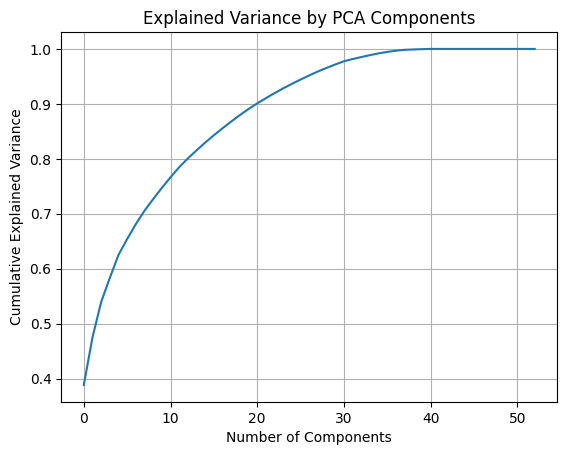

Number of PCA components to retain 99% variance: 35


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
# Standardize the features
from sklearn.preprocessing import StandardScaler
# Separate features and target variable
X = health.drop(columns=["Health Opportunity Index"], axis=1)
y = health["Health Opportunity Index"].copy()

# Define the numeric pipeline with imputation and scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

# Apply the pipeline to the data
X_prepared = num_pipeline.fit_transform(X)

# Perform PCA
pca = PCA().fit(X_prepared)

# Plot the cumulative explained variance ratio
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Choose the number of components that capture 99% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99) + 1
print(f'Number of PCA components to retain 99% variance: {n_components}')

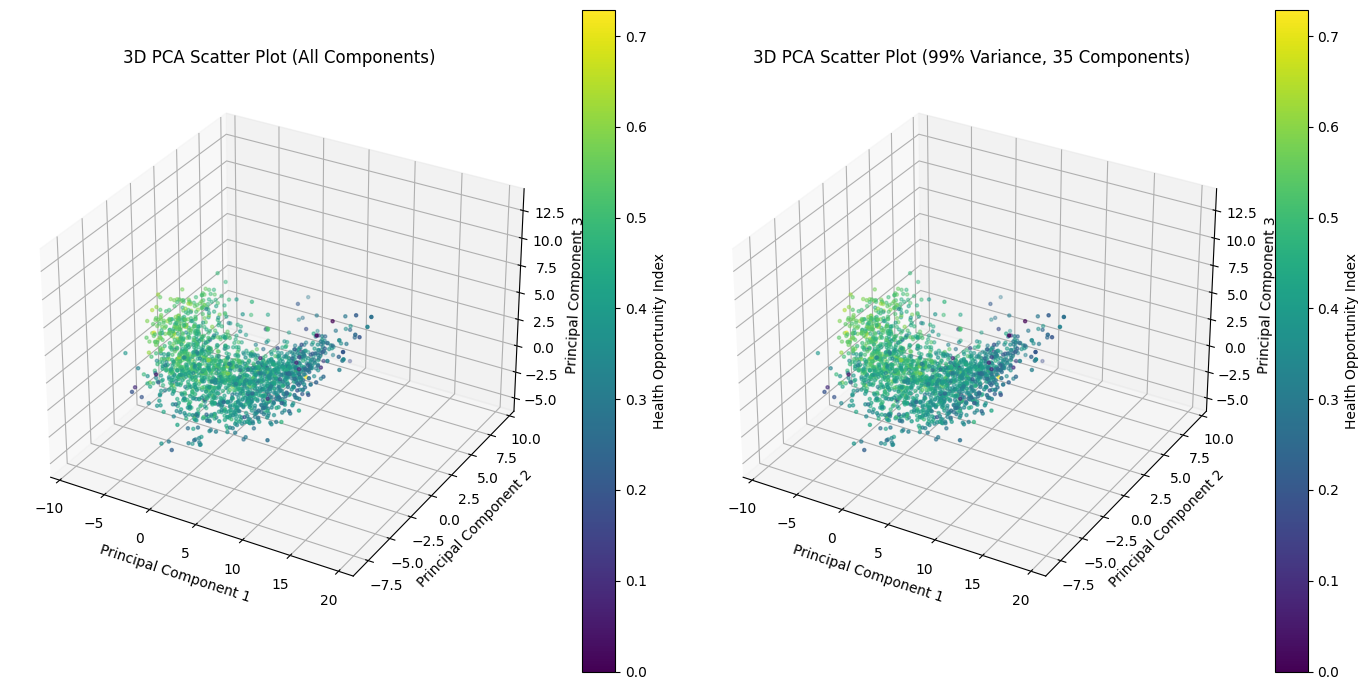

In [ ]:
# Perform PCA with all components
pca_all = PCA(n_components=X_prepared.shape[1])
X_train_pca_all = pca_all.fit_transform(X_prepared)

# Perform PCA with 99% variance retained
pca_99 = PCA(n_components=35)
X_train_pca_99 = pca_99.fit_transform(X_prepared)


# Create a 3D scatter plot for all components
fig = plt.figure(figsize=(14, 7))

ax_all = fig.add_subplot(121, projection='3d')
sc_all = ax_all.scatter(X_train_pca_all[:, 0], X_train_pca_all[:, 1], X_train_pca_all[:, 2], c=y, cmap='viridis', s=5)
ax_all.set_xlabel('Principal Component 1')
ax_all.set_ylabel('Principal Component 2')
ax_all.set_zlabel('Principal Component 3')
ax_all.set_title('3D PCA Scatter Plot (All Components)')
plt.colorbar(sc_all, ax=ax_all, label='Health Opportunity Index')

# Create a 3D scatter plot for 99% variance components
ax_99 = fig.add_subplot(122, projection='3d')
sc_99 = ax_99.scatter(X_train_pca_99[:, 0], X_train_pca_99[:, 1], X_train_pca_99[:, 2], c=y, cmap='viridis', s=5)
ax_99.set_xlabel('Principal Component 1')
ax_99.set_ylabel('Principal Component 2')
ax_99.set_zlabel('Principal Component 3')
ax_99.set_title('3D PCA Scatter Plot (99% Variance, 35 Components)')
plt.colorbar(sc_99, ax=ax_99, label='Health Opportunity Index')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
# num_pipeline = Pipeline([
#         ('imputer', SimpleImputer(strategy="median")),
#         ('std_scaler', StandardScaler()),
#     ])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
    ('pca', PCA(n_components=35))
])

num_attribs = list(X_train)
print(num_attribs)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

['% Households: Less than $30,000', '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty', '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level', '% Households: Less than $10,000', '% Households: $100,000 or More', '% Households: $150,000 to $199,999', '% Families: Income At or Above Poverty Level', '% Families: Income Below Poverty Level', '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level', '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty', 'Gini Index', '% Households: $10,000 to $14,999', '% Households: $125,000 to $149,999', '% Total: with Health Insurance Coverage: Private Health Insurance', 'Median Family Income (In 2017 Inflation Adjusted Dollars)', '% Households: $20,000 to $24,999', '% Households: $15,000 to $19,999', 'Renter-Occupied Housing Units', '% Renter-Occupied Housing Units: Less than $1,000', '% Househol

In [ ]:
print(health_data.shape)
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(1874, 54)
(1499, 35)
(375, 35)


### Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor  # Import XGBoost Regressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Dictionary to hold the performance metrics of the models
model_performance = {}


# Decision Tree Regression
dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_dt.fit(X_train_prepared, y_train)
print("Decistion Tree Best params: ", grid_search_dt.best_params_)
dt = grid_search_dt.best_estimator_
y_pred_dt = dt.predict(X_test_prepared)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
model_performance['Decision Tree'] = (mse_dt, mae_dt, r2_dt)

# Random Forest Regression
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_prepared, y_train)
print("Random Forest Best params: ", grid_search_rf.best_params_)
rf = grid_search_rf.best_estimator_
y_pred_rf = rf.predict(X_test_prepared)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
model_performance['Random Forest'] = (mse_rf, mae_rf, r2_rf)

# XGBoost Regression
xgb = XGBRegressor(random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.45, 0.5, 0.55],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_prepared, y_train)
print("XGBoost Best params: ", grid_search_xgb.best_params_)
xgb = grid_search_xgb.best_estimator_
y_pred_xgb = xgb.predict(X_test_prepared)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
model_performance['XGBoost'] = (mse_xgb, mae_xgb, r2_xgb)

# Print model performance
for model, metrics in model_performance.items():
    print(f"{model}:")
    print(f"  MSE: {metrics[0]}")
    print(f"  MAE: {metrics[1]}")
    print(f"  R^2: {metrics[2]}")
    print("------")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Decistion Tree Best params:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random Forest Best params:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost Best params:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.5}
Decision Tree:
  MSE: 0.004419157586376444
  MAE: 0.05218106335025707
  R^2: 0.40536822834921227
------
Random Forest:
  MSE: 0.0028121905848296786
  MAE: 0.0419110120389235
  R^2: 0.6215980451043166
------
XGBoost:
  MSE: 0.0028998755140796596
  MAE: 0.04254896896790787
  R^2: 0.6097993608963286
------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `grid_search` is your GridSearchCV object
# and `param_grid` is your dictionary of parameters

def plot_grid_search_results(grid_search, param_grid, score):
    results = pd.DataFrame(grid_search.cv_results_)
    segments = len(param_grid)
    dim_names = list(param_grid.keys())

    min_loc = np.argmin(results['mean_test_score'])
    min_ind = []
    for p in range(segments - 1, -1, -1):
        min_ind.append((min_loc // (segments ** p)) % segments)

    print("Feature Importances")
    for i in range(len(min_ind)):
        print(dim_names[i] + ":", min_ind[i])

    hf = plt.figure(figsize=(20, 8), dpi=125)
    x = np.arange(1.0 / segments, 1 + (1.0 / segments), 1.0 / segments)
    y = copy.copy(x)
    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D

    i = 1
    for dim1 in range(segments):
        for dim2 in range(dim1 + 1, segments):
            other_axes = tuple(axis for axis in range(segments) if axis not in (dim1, dim2))
            ha = hf.add_subplot(2, 5, i, projection='3d')
            ha.set_ylabel(dim_names[dim1])  # rows, or first dimension correspond to y
            ha.set_xlabel(dim_names[dim2])  # columns, or second dimension correspond to x
            # We average the scores across all the other dimensions so we can visualize 2 at a time
            ha.plot_surface(X, Y, np.mean(results['mean_test_score'].values.reshape(len(param_grid[dim_names[0]]), -1), axis=other_axes), cmap='cubehelix')
            ha.view_init(20, -150)
            i += 1

    plt.tight_layout()
    plt.show()

# Example parameter grid used in GridSearchCV
param_grid_rf = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Assuming grid_search_rf is your GridSearchCV object for Random Forest
plot_grid_search_results(grid_search_rf, param_grid_rf, 'neg_mean_squared_error')


AttributeError: 'dict' object has no attribute 'cv_results_'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor  # Import XGBoost Regressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Dictionary to hold the performance metrics of the models
model_performance = {}


# Decision Tree Regression
dt = DecisionTreeRegressor(**{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}, random_state=42)
dt.fit(X_train_prepared, y_train)
y_pred_dt = dt.predict(X_test_prepared)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
model_performance['Decision Tree'] = (mse_dt, mae_dt, r2_dt)


rf = RandomForestRegressor(**{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100},random_state=42)
rf.fit(X_train_prepared, y_train)
y_pred_rf = rf.predict(X_test_prepared)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf= r2_score(y_test, y_pred_rf)
model_performance['Random Forest'] = (mse_rf, mae_rf, r2_rf)


# XGBoost Regression
xgb = XGBRegressor(**{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.5}, random_state=42)
xgb.fit(X_train_prepared, y_train)
y_pred_xgb = xgb.predict(X_test_prepared)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
model_performance['XGBoost'] = (mse_xgb, mae_xgb, r2_xgb)

for model, metrics in model_performance.items():
    print(f"{model}:")
    print(f"  MSE: {metrics[0]}")
    print(f"  MAE: {metrics[1]}")
    print(f"  R^2: {metrics[2]}")
    print("------")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Decision Tree:
  MSE: 0.004419157586376444
  MAE: 0.05218106335025707
  R^2: 0.40536822834921227
------
Random Forest:
  MSE: 0.0028121905848296786
  MAE: 0.0419110120389235
  R^2: 0.6215980451043166
------
XGBoost:
  MSE: 0.0028998755140796596
  MAE: 0.04254896896790787
  R^2: 0.6097993608963286
------


In [ ]:
X_new_prepared = full_pipeline.transform(health_data)

In [ ]:
# Step 2: Make Predictions
new_predictions = xgb.predict(X_new_prepared)

# Step 3: Attach Predictions to VA HOI Dataset
health_data['Predicted_Health_Opportunity_Index'] = new_predictions

sorted_health = health_data.sort_values(by='Predicted_Health_Opportunity_Index')

sorted_health.to_csv("VA_xgb_results.csv", index=False)
sorted_health

<ipython-input-28-0578e30bdaf2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_data['Predicted_Health_Opportunity_Index'] = new_predictions


,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,"% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999,Health Opportunity Index,Predicted_Health_Opportunity_Index
1,72.92,71.48,28.52,32.93,14.15,1.71,73.33,26.67,0.00,100.00,...,0.00,0.00,2.44,0.00,19028.78000,16.16,2.44,22.56,0.015558,0.019776
0,64.91,69.37,30.63,58.77,3.07,0.00,82.76,17.24,100.00,0.00,...,0.00,7.62,0.00,4.29,3673.54200,6.67,0.00,2.38,0.000000,0.037382
2,10.59,8.45,91.55,3.31,59.23,16.20,91.77,8.23,48.23,51.77,...,14.24,0.00,5.01,21.03,44220.11000,3.91,15.92,3.06,0.032861,0.065756
3,58.56,55.08,44.92,16.15,6.41,0.00,72.04,27.96,61.98,38.02,...,1.66,7.64,7.27,4.32,10131.44000,6.81,1.48,11.46,0.077873,0.082269
4,48.60,51.00,49.00,19.54,25.41,5.15,94.69,5.31,100.00,0.00,...,3.23,3.86,3.06,7.35,17905.62000,1.35,4.30,13.90,0.085121,0.085945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,1.35,0.96,99.04,0.00,90.21,18.12,98.57,1.43,97.37,2.63,...,0.00,0.00,0.73,0.00,4420.11000,66.67,4.77,0.00,0.623103,0.622243
1868,2.52,1.49,98.51,0.00,72.41,17.41,98.80,1.20,98.59,1.41,...,0.00,0.00,2.57,65.52,1182.87500,34.48,9.09,0.00,0.631906,0.622703
1870,6.83,3.59,96.41,1.67,65.63,20.28,97.60,2.40,95.97,4.03,...,8.94,0.00,0.86,42.28,1807.66700,8.94,13.18,8.94,0.638278,0.632571
1872,2.54,1.45,98.55,0.36,82.27,23.06,98.70,1.30,98.30,1.70,...,16.96,0.00,3.18,42.11,1256.83700,11.11,9.64,0.00,0.687327,0.672894


In [ ]:
# Step 2: Make Predictions
new_predictions = rf.predict(X_new_prepared)

# Step 3: Attach Predictions to VA HOI Dataset
health_data['Predicted_Health_Opportunity_Index'] = new_predictions

sorted_health = health_data.sort_values(by='Predicted_Health_Opportunity_Index')

sorted_health.to_csv("VA_rf_results.csv", index=False)
sorted_health

<ipython-input-29-56438216cf1f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_data['Predicted_Health_Opportunity_Index'] = new_predictions


,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,"% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999,Health Opportunity Index,Predicted_Health_Opportunity_Index
1,72.92,71.48,28.52,32.93,14.15,1.71,73.33,26.67,0.00,100.00,...,0.00,0.00,2.44,0.00,19028.78000,16.16,2.44,22.56,0.015558,0.075637
0,64.91,69.37,30.63,58.77,3.07,0.00,82.76,17.24,100.00,0.00,...,0.00,7.62,0.00,4.29,3673.54200,6.67,0.00,2.38,0.000000,0.093907
2,10.59,8.45,91.55,3.31,59.23,16.20,91.77,8.23,48.23,51.77,...,14.24,0.00,5.01,21.03,44220.11000,3.91,15.92,3.06,0.032861,0.118231
3,58.56,55.08,44.92,16.15,6.41,0.00,72.04,27.96,61.98,38.02,...,1.66,7.64,7.27,4.32,10131.44000,6.81,1.48,11.46,0.077873,0.132275
7,60.21,66.87,33.13,26.94,6.73,1.45,68.04,31.96,49.09,50.91,...,2.11,0.00,4.04,2.61,14843.08000,5.84,7.15,24.35,0.101564,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,2.52,1.49,98.51,0.00,72.41,17.41,98.80,1.20,98.59,1.41,...,0.00,0.00,2.57,65.52,1182.87500,34.48,9.09,0.00,0.631906,0.593687
1873,76.47,47.83,52.17,0.00,0.00,0.00,50.00,50.00,NaN,NaN,...,NaN,NaN,0.00,NaN,35.91853,NaN,0.00,NaN,0.728815,0.599260
1870,6.83,3.59,96.41,1.67,65.63,20.28,97.60,2.40,95.97,4.03,...,8.94,0.00,0.86,42.28,1807.66700,8.94,13.18,8.94,0.638278,0.599342
1867,13.06,8.77,91.23,2.25,53.37,15.45,97.67,2.33,92.72,7.28,...,9.23,0.00,3.09,26.92,7046.65900,23.85,13.62,3.08,0.625536,0.601673


## Apply Trained Model to Other States (California)

In [ ]:
import pandas as pd

# Load the datasets
hoi_cal = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/Cali_HOI.csv')

<ipython-input-30-5c4ef128cf7d>:4: DtypeWarning: Columns (0,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265

In [ ]:
# Find the number of entries in the dataset
print(f"The dataset have {hoi_cal.shape[0]} entries (rows)")

The dataset have 8058 entries (rows)


In [ ]:
# Find the number of features in the dataset
print(f"The dataset have {hoi_cal.shape[1]} features (columns)")

The dataset have 269 features (columns)


In [ ]:
import pandas as pd

# Load the datasets
hoi_cal = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/Cali_HOI.csv')
hoi_new = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/HOI_new.csv')

hoi_cal['Census Tract'] = hoi_cal['FIPS']

# Identify columns that are in hoi_new but not in hoi_cal
columns_in_new_not_in_cal = [col for col in hoi_new.columns if col not in hoi_cal.columns]

columns_in_new_not_in_cal

# Step 3: Drop any empty columns and perform additional necessary cleaning
hoi_cal_cleaned = hoi_cal.dropna(axis=1, how='all')

hoi_cal_cleaned = hoi_cal_cleaned.drop(labels = 0, axis = 0)
# Drop the specified "rubbish" columns from the final dataset
columns_to_drop = [
    "FIPS", "Area Name","State/U.S.-Abbreviation (USPS)", "State/U.S.-Abbreviation (USPS)", "File Identification", "Qualifying Name", "State Postal Abbreviation",
    "Summary Level", "Geographic Component", "File identification",
    "Logical Record Number", "State (FIPS Code)", "County of current residence",
    "Census Tract_y", "Geographic Identifier", "Total Population.1"
]
# Drop these columns, being careful to only drop those that exist in the dataframe to avoid KeyError
hoi_cal_final_cleaned = hoi_cal_cleaned.drop(columns=[col for col in columns_to_drop if col in hoi_cal_cleaned.columns])
hoi_cal_final_cleaned.to_csv("Cali_HOI_cleaned.csv", index= False)

# Combine several columns to simplify data
def sum_attr(row, col_names):
  sum = 0
  for col_name in col_names:
    sum += float(row[col_name])
  return sum


hoi_cal_final_cleaned['% Households: Less than $30,000'] = hoi_cal_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: Less than $10,000", "% Households: $10,000 to $14,999",
     "% Households: $15,000 to $19,999", "% Households: $20,000 to $24,999",
     "% Households: $25,000 to $29,999"]
  ), axis=1)

hoi_cal_final_cleaned['% Households: $30,000 to $99,999'] = hoi_cal_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: $30,000 to $34,999", "% Households: $35,000 to $39,999",
     "% Households: $40,000 to $44,999", "% Households: $45,000 to $49,999",
     "% Households: $50,000 to $59,999", "% Households: $60,000 to $74,999",
     "% Households: $75,000 to $99,999"]
  ), axis=1)


hoi_cal_final_cleaned['% Households: $100,000 or More'] = hoi_cal_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: $100,000 to $124,999", "% Households: $125,000 to $149,999",
     "% Households: $150,000 to $199,999", "% Households: $200,000 or More"]
  ), axis=1)

hoi_cal_final_cleaned['% Renter-Occupied Housing Units: Less than $1,000'] = hoi_cal_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Renter-Occupied Housing Units: Less than $300", "% Renter-Occupied Housing Units: $300 to $499",
     "% Renter-Occupied Housing Units: $500 to $799", "% Renter-Occupied Housing Units: $800 to $999"]
  ), axis=1)


hoi_cal_final_cleaned['% Renter-Occupied Housing Units: $1,000 to $2,499'] = hoi_cal_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Renter-Occupied Housing Units: $1,000 to $1,499", "% Renter-Occupied Housing Units: $1,500 to $1,999",
     "% Renter-Occupied Housing Units: $2,000 to $2,499", "% Renter-Occupied Housing Units: $2,500 to $2,999"]
  ), axis=1)

columns_to_drop_after_aggregation = [
    "Households: Less than $10,000",
    "Households: $10,000 to $14,999",
    "Households: $15,000 to $19,999",
    "Households: $20,000 to $24,999",
    "Households: $25,000 to $29,999",
    "Households: $30,000 to $34,999",
    "Households: $35,000 to $39,999",
    "Households: $40,000 to $44,999",
    "Households: $45,000 to $49,999",
    "Households: $50,000 to $59,999",
    "Households: $60,000 to $74,999",
    "Households: $75,000 to $99,999",
    "Households: $100,000 to $124,999",
    "Households: $125,000 to $149,999",
    "Households: $150,000 to $199,999",
    "Households: $200,000 or More",
    "Renter-Occupied Housing Units: Less than $300",
    "Renter-Occupied Housing Units: $300 to $499",
    "Renter-Occupied Housing Units: $500 to $799",
    "Renter-Occupied Housing Units: $800 to $999",
    "Renter-Occupied Housing Units: $1,000 to $1,499",
    "Renter-Occupied Housing Units: $1,500 to $1,999",
    "Renter-Occupied Housing Units: $2,000 to $2,499",
    "Renter-Occupied Housing Units: $2,500 to $2,999",
]

hoi_cal_final_cleaned_merged = hoi_cal_final_cleaned.drop(columns=[col for col in columns_to_drop_after_aggregation if col in hoi_cal_final_cleaned.columns])


# Specify additional columns to drop based on the extended list provided
columns_to_drop_extended = [
    "Area (Land).1",
    "Renter-Occupied Housing Units: Householder 15 to 24 Years",
    "Renter-Occupied Housing Units: Householder 25 to 34 Years",
    "Renter-Occupied Housing Units: Householder 35 to 44 Years",
    "Renter-Occupied Housing Units: Householder 45 to 54 Years",
    "Renter-Occupied Housing Units: Householder 55 to 59 Years",
    "Renter-Occupied Housing Units: Householder 60 to 64 Years",
    "Renter-Occupied Housing Units: Householder 65 to 74 Years",
    "Renter-Occupied Housing Units: Householder 75 to 84 Years",
    "Renter-Occupied Housing Units: Householder 85 Years and Over",
    "Population 3 Years and Over: Enrolled in School",
    "Population 3 Years and Over: Not Enrolled in School",
    "Civilian Population 16 to 19 Years: Not High School Graduate, Not Enrolled (Dropped Out)",
    "Civilian Population 16 to 19 Years: High School Graduate, or Enrolled (In School)",
    "Civilian Population in Labor Force 16 Years and Over: Employed",
    "Civilian Population in Labor Force 16 Years and Over: Unemployed",
    "Households: Less than $10,000",
    "Households: $10,000 to $14,999",
    "Households: $15,000 to $19,999",
    "Households: $20,000 to $24,999",
    "Households: $25,000 to $29,999",
    "Households: $30,000 to $34,999",
    "Households: $35,000 to $39,999",
    "Households: $40,000 to $44,999",
    "Households: $45,000 to $49,999",
    "Households: $50,000 to $59,999",
    "Households: $60,000 to $74,999",
    "Households: $75,000 to $99,999",
    "Households: $100,000 to $124,999",
    "Households: $125,000 to $149,999",
    "Households: $150,000 to $199,999",
    "Households: $200,000 or More",
    "Renter-Occupied Housing Units.1",
    "Renter-Occupied Housing Units: Less than $300",
    "Renter-Occupied Housing Units: $300 to $499",
    "Renter-Occupied Housing Units: $500 to $799",
    "Renter-Occupied Housing Units: $800 to $999",
    "Renter-Occupied Housing Units: $1,000 to $1,499",
    "Renter-Occupied Housing Units: $1,500 to $1,999",
    "Renter-Occupied Housing Units: $2,000 to $2,499",
    "Renter-Occupied Housing Units: $2,500 to $2,999",
    "Renter-Occupied Housing Units: $3,000 or More",
    "Renter-Occupied Housing Units: No Cash Rent",
    "Renter-Occupied Housing Units.2",
    "Renter-Occupied Housing Units: Less than $20,000",
    "Renter-Occupied Housing Units: Less than $20,000: Less than 20 Percent",
    "Renter-Occupied Housing Units: Less than $20,000: 20 to 29 Percent",
    "Renter-Occupied Housing Units: Less than $20,000: 30 Percent or More",
    "Renter-Occupied Housing Units: $20,000 to $34,999",
    "Renter-Occupied Housing Units: $20,000 to $34,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $20,000 to $34,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $20,000 to $34,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $35,000 to $49,999",
    "Renter-Occupied Housing Units: $35,000 to $49,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $35,000 to $49,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $35,000 to $49,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $50,000 to $74,999",
    "Renter-Occupied Housing Units: $50,000 to $74,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $50,000 to $74,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $50,000 to $74,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $75,000 or More",
    "Renter-Occupied Housing Units: $75,000 or More: Less than 20 Percent",
    "Renter-Occupied Housing Units: $75,000 or More: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $75,000 or More: 30 Percent or More",
    "Renter-Occupied Housing Units: Zero or Negative Income",
    "Renter-Occupied Housing Units: No Cash Rent.1",
    "% Renter-Occupied Housing Units: Less than $20,000",
    "% Renter-Occupied Housing Units: Less than $20,000: Less than 20 Percent",
    "% Renter-Occupied Housing Units: Less than $20,000: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: Less than $20,000: 30 Percent or More",
    "% Renter-Occupied Housing Units: $20,000 to $34,999",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $35,000 to $49,999",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $50,000 to $74,999",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $75,000 or More",
    "% Renter-Occupied Housing Units: $75,000 or More: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $75,000 or More: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $75,000 or More: 30 Percent or More",
    "% Renter-Occupied Housing Units: Zero or Negative Income",
    "% Renter-Occupied Housing Units: No Cash Rent.1",
    "Families: Income Below Poverty Level",
    "Families: Income Below Poverty Level: Married Couple Family: with Related Child Living Below Poverty Level",
    "Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years",
    "Families: Income At or Above Poverty Level",
    "% Families: Income Below Poverty Level: Married Couple Family: with Related Child Living Below Poverty Level",
    "% Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined:",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined:",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined:",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined: At or Above Poverty Level",
    "Population for Whom Poverty Status Is Determined:",
    "Population for Whom Poverty Status Is Determined: Under .50",
    "Population for Whom Poverty Status Is Determined: .50 to .74",
    "Population for Whom Poverty Status Is Determined: .75 to .99",
    "Population for Whom Poverty Status Is Determined: 1.00 to 1.49",
    "Population for Whom Poverty Status Is Determined: 1.50 to 1.99",
    "Population for Whom Poverty Status Is Determined: 2.00 and Over",
    "% Population for Whom Poverty Status Is Determined: Under .50",
    "% Population for Whom Poverty Status Is Determined: .50 to .74",
    "% Population for Whom Poverty Status Is Determined: .75 to .99",
    "% Population for Whom Poverty Status Is Determined: 1.00 to 1.49",
    "% Population for Whom Poverty Status Is Determined: 1.50 to 1.99",
    "% Population for Whom Poverty Status Is Determined: 2.00 and Over",
    "Total: No Health Insurance Coverage",
    "Total: with Health Insurance Coverage",
    "Total: with Health Insurance Coverage: Public Health Coverage",
    "Total: with Health Insurance Coverage: Private Health Insurance",
    "Population 16 Years and Over: in Labor Force",
    "Population 16 Years and Over: in Labor Force: in Armed Forces",
    "Population 16 Years and Over: in Labor Force: Civilian",
    "Population 16 Years and Over: in Labor Force: Civilian: Employed",
    "Population 16 Years and Over: in Labor Force: Civilian: Unemployed",
    "Population 16 Years and Over: Not in Labor Force",

]

hoi_cal_final_cleaned_extended = hoi_cal_final_cleaned_merged.drop(columns=[col for col in columns_to_drop_extended if col in hoi_cal_final_cleaned_merged.columns])

# Show the final row count and a preview of the cleaned dataset
hoi_cal_final_cleaned_extended.to_csv("Cleaned_cal.csv", index=False)
hoi_cal_final_cleaned_extended

<ipython-input-33-247f72cbbbab>:4: DtypeWarning: Columns (0,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265

,Name of Area,US,Region,Division,State (Census Code),State (FIPS),County,County Subdivision (FIPS),Place (FIPS Code),Place (State FIPS + Place FIPS),...,Total:,% Total: No Health Insurance Coverage,% Total: with Health Insurance Coverage,% Total: with Health Insurance Coverage: Public Health Coverage,% Total: with Health Insurance Coverage: Private Health Insurance,"% Households: Less than $30,000","% Households: $30,000 to $99,999","% Households: $100,000 or More","% Renter-Occupied Housing Units: Less than $1,000","% Renter-Occupied Housing Units: $1,000 to $2,499"
1,"Census Tract 4001, Alameda County, California",NaN,NaN,NaN,NaN,06,001,NaN,NaN,NaN,...,2991,1.57,98.43,26.78,89.9,9.73,17.79,72.49,6.00,15.99
2,"Census Tract 4002, Alameda County, California",NaN,NaN,NaN,NaN,06,001,NaN,NaN,NaN,...,1997,3.3,96.7,22.23,89.53,3.14,27.53,69.33,2.70,86.19
3,"Census Tract 4003, Alameda County, California",NaN,NaN,NaN,NaN,06,001,NaN,NaN,NaN,...,5123,3.03,96.97,16.05,89.19,20.05,37.10,42.84,24.19,65.55
4,"Census Tract 4004, Alameda County, California",NaN,NaN,NaN,NaN,06,001,NaN,NaN,NaN,...,3986,3.36,96.64,20.62,86.38,15.79,32.14,52.07,11.23,83.65
5,"Census Tract 4005, Alameda County, California",NaN,NaN,NaN,NaN,06,001,NaN,NaN,NaN,...,3944,6.29,93.71,16.76,83.49,15.50,36.48,48.00,12.47,80.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8053,"Census Tract 408, Yuba County, California",NaN,NaN,NaN,NaN,6,115,NaN,NaN,NaN,...,4497,9.61,90.39,29.46,72.83,14.97,51.82,33.20,51.62,48.37
8054,"Census Tract 409.01, Yuba County, California",NaN,NaN,NaN,NaN,6,115,NaN,NaN,NaN,...,3080,11.62,88.38,52.4,48.77,39.03,35.04,25.95,26.17,63.09
8055,"Census Tract 409.02, Yuba County, California",NaN,NaN,NaN,NaN,6,115,NaN,NaN,NaN,...,777,2.06,97.94,12.87,88.67,24.23,65.07,10.71,1.41,94.65
8056,"Census Tract 410, Yuba County, California",NaN,NaN,NaN,NaN,6,115,NaN,NaN,NaN,...,7336,4.93,95.07,43.73,70.67,16.65,52.81,30.55,36.06,58.20


In [ ]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)

def load_health_data():
    health = pd.read_csv('Cleaned_cal.csv')
    # health = pd.read_csv('Cali_HOI_cleaned.csv')
    return health

health_cal = load_health_data()
# Display the first n rows of the data. (n=5 by default, we will use 10 rows)
health_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8057 entries, 0 to 8056
Columns: 129 entries, Name of Area to % Renter-Occupied Housing Units: $1,000 to $2,499
dtypes: float64(113), int64(15), object(1)
memory usage: 7.9+ MB


In [ ]:
# List of columns from the Virginia training dataset, excluding the target variable
training_columns = list(health_data.columns)
training_columns.remove('Health Opportunity Index')
training_columns.remove('Predicted_Health_Opportunity_Index')

# Align health_cal with these columns, ensuring it only includes them
# Drop columns in health_cal not present in training_columns
health_cal_aligned = health_cal[[col for col in health_cal.columns if col in training_columns]]

# # Check for any missing columns in health_cal_aligned and add them with default values (e.g., 0)
# for col in training_columns:
#     if col not in health_cal_aligned.columns:
#         health_cal_aligned[col] = 0  # You might choose a different default value based on your data's nature

# Ensure the order of columns in health_cal_aligned matches training_columns order
health_cal_aligned = health_cal_aligned[training_columns]

health_cal_aligned

# Before proceeding to prediction, remember to apply the same preprocessing steps (e.g., scaling) to health_cal_aligned
# as were applied to your training data.

# Example for scaling (assuming you've fitted a scaler on your training data):
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(va_final[training_columns])  # Assuming va_final is your training data
# health_cal_aligned_scaled = scaler.transform(health_cal_aligned)

# Now, health_cal_aligned is ready for prediction with your trained model

,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,% Population 16 Years and Over: in Labor Force: Civilian: Unemployed,"% Renter-Occupied Housing Units: $1,000 to $2,499","% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999
0,9.73,3.88,96.12,1.91,72.49,9.41,97.30,2.70,91.60,8.40,...,2.48,15.99,5.33,0.00,0.00,28.67,1123.62500,6.00,7.50,6.00
1,3.14,5.79,94.21,1.09,69.33,12.20,98.76,1.24,98.06,1.94,...,2.85,86.19,17.42,0.00,3.02,25.23,8804.50400,12.91,8.21,2.70
2,20.05,8.69,91.31,3.25,42.84,12.53,98.39,1.61,100.00,0.00,...,4.35,65.55,4.33,0.00,5.41,18.34,12004.13000,15.74,13.51,11.34
3,15.79,8.75,91.25,3.36,52.07,15.79,95.28,4.72,90.46,9.54,...,3.89,83.65,10.88,0.80,1.12,23.08,14462.34000,13.26,13.16,6.37
4,15.50,12.04,87.96,2.77,48.00,12.06,99.34,0.66,100.00,0.00,...,2.06,80.64,4.22,1.92,4.55,18.31,17304.41000,13.71,13.48,6.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,14.97,9.44,90.56,1.33,33.20,10.71,94.41,5.59,90.36,9.64,...,6.31,48.37,0.00,11.66,3.06,22.81,106.72320,22.81,9.71,11.49
8053,39.03,24.31,75.69,4.55,25.95,3.41,77.06,22.94,57.86,42.14,...,7.53,63.09,0.00,0.00,1.80,18.73,30.25635,14.88,12.22,8.26
8054,24.23,7.99,92.01,7.89,10.71,0.00,89.30,10.70,86.55,13.45,...,2.96,94.65,3.10,0.00,7.04,16.90,42.32862,15.49,19.15,0.00
8055,16.65,7.72,92.28,3.19,30.55,11.53,93.60,6.40,81.42,18.58,...,2.86,58.20,18.65,3.89,4.26,14.14,40.72453,3.28,20.12,3.28


In [ ]:
# Find the number of entries in the dataset
print(f"The dataset have {health_cal_aligned.shape[0]} entries (rows)")

The dataset have 8057 entries (rows)


In [ ]:
# Find the number of features in the dataset
print(f"The dataset have {health_cal_aligned.shape[1]} features (columns)")

The dataset have 53 features (columns)


In [ ]:
X_new_prepared = full_pipeline.transform(health_cal_aligned)

In [ ]:
# Step 2: Make Predictions
new_predictions = rf.predict(X_new_prepared)

# Step 3: Attach Predictions to New Dataset (Optional)
health_cal_aligned['Predicted_Health_Opportunity_Index'] = new_predictions

sorted_health_cal = health_cal_aligned.sort_values(by='Predicted_Health_Opportunity_Index')

sorted_health_cal.to_csv("Cali_rf_result.csv", index = False)

sorted_health_cal

,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,"% Renter-Occupied Housing Units: $1,000 to $2,499","% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999,Predicted_Health_Opportunity_Index
1906,50.18,42.28,57.72,8.07,7.62,3.05,55.49,44.51,42.73,57.27,...,52.99,0.63,0.00,10.28,24.37,25060.640000,25.91,6.25,19.02,0.296050
1876,40.06,32.50,67.50,11.82,7.64,1.98,60.84,39.16,52.40,47.60,...,53.82,0.00,0.00,14.44,40.32,23615.830000,29.43,8.07,18.54,0.297252
1916,48.89,33.35,66.65,9.23,3.77,0.52,64.09,35.91,53.04,46.96,...,57.39,0.00,6.81,6.19,17.39,24379.560000,21.59,10.60,23.77,0.297252
958,41.55,27.47,72.53,7.94,11.27,1.30,71.15,28.85,52.49,47.51,...,29.84,0.00,16.02,6.64,18.22,4067.864000,13.18,7.83,8.27,0.297252
5732,54.53,28.67,71.33,10.82,6.04,0.00,64.96,35.04,37.41,62.59,...,66.56,1.21,0.00,7.38,33.99,19607.960000,17.60,7.97,22.66,0.297252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,15.32,14.22,85.78,6.22,37.32,8.37,100.00,0.00,100.00,0.00,...,32.61,0.00,20.50,4.55,47.20,4.576529,10.56,12.20,6.52,0.476877
2692,0.00,0.00,100.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,...,100.00,0.00,0.00,0.00,0.00,2.849322,100.00,0.00,0.00,0.477143
5817,32.18,45.82,54.18,15.65,27.82,7.70,94.96,5.04,95.35,4.65,...,95.31,0.78,0.00,4.22,15.47,464.560600,3.59,17.02,3.28,0.477371
5700,46.81,61.20,38.80,23.52,31.44,4.54,98.14,1.86,100.00,0.00,...,75.96,0.00,3.46,1.28,7.69,2738.859000,0.00,6.05,5.19,0.477736


In [ ]:
# Step 2: Make Predictions
new_predictions = xgb.predict(X_new_prepared)

# Step 3: Attach Predictions to New Dataset (Optional)
health_cal_aligned['Predicted_Health_Opportunity_Index'] = new_predictions

sorted_health_cal = health_cal_aligned.sort_values(by='Predicted_Health_Opportunity_Index')


sorted_health_cal.to_csv("Cali_xgb_result.csv", index = False)

sorted_health_cal

,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,"% Renter-Occupied Housing Units: $1,000 to $2,499","% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999,Predicted_Health_Opportunity_Index
6300,55.96,29.20,70.80,16.41,15.30,3.09,79.30,20.70,73.72,26.28,...,25.18,3.96,21.78,6.87,11.03,71338.690,19.94,9.82,6.22,0.346435
4835,46.51,24.94,75.06,5.54,14.38,4.04,83.96,16.04,12.00,88.00,...,33.15,0.00,0.00,3.97,17.85,4172.888,15.70,7.34,43.22,0.348382
4705,56.61,15.56,84.44,8.96,9.09,0.51,93.74,6.26,100.00,0.00,...,42.80,0.00,0.00,2.50,0.00,3097.552,1.56,5.51,33.66,0.349190
1978,43.08,28.23,71.77,9.19,5.50,1.39,68.81,31.19,48.95,51.05,...,58.27,0.00,0.00,8.14,20.13,15173.010,42.27,9.88,15.73,0.349613
2496,44.86,27.43,72.57,6.93,6.39,1.25,70.71,29.29,50.92,49.08,...,52.82,1.41,1.13,6.07,27.21,17197.350,17.42,5.69,31.54,0.349613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,85.37,88.83,11.17,66.15,0.00,0.00,0.00,100.00,NaN,NaN,...,73.07,16.15,0.00,0.00,0.00,13133.700,3.85,2.31,0.00,0.481449
973,64.96,38.54,61.46,15.05,2.62,0.41,66.67,33.33,54.14,45.86,...,9.34,0.00,17.28,3.78,17.12,3600.038,20.31,0.87,27.60,0.482684
1008,60.15,51.04,48.96,21.01,2.23,0.00,44.31,55.69,32.69,67.31,...,14.52,0.00,7.81,1.94,25.40,7092.382,16.60,5.61,27.96,0.484151
998,54.44,49.33,50.67,14.94,0.73,0.56,44.93,55.07,24.86,75.14,...,18.64,0.00,7.69,1.00,15.21,10197.500,15.92,5.76,19.41,0.490036


## County Life expectancy Generation for CA

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/CA_county_ct.csv')

# Create a mapping from FIPS code to county name (only partial FIPS shown for brevity)
fips_to_county = {
    6001: 'Alameda County',
    6003: 'Alpine County',
    6005: 'Amador County',
    6007: 'Butte County',
    6009: 'Calaveras County',
    6011: 'Colusa County',
    6013: 'Contra Costa County',
    6015: 'Del Norte County',
    6017: 'El Dorado County',
    6019: 'Fresno County',
    6021: 'Glenn County',
    6023: 'Humboldt County',
    6025: 'Imperial County',
    6027: 'Inyo County',
    6029: 'Kern County',
    6031: 'Kings County',
    6033: 'Lake County',
    6035: 'Lassen County',
    6037: 'Los Angeles County',
    6039: 'Madera County',
    6041: 'Marin County',
    6043: 'Mariposa County',
    6045: 'Mendocino County',
    6047: 'Merced County',
    6049: 'Modoc County',
    6051: 'Mono County',
    6053: 'Monterey County',
    6055: 'Napa County',
    6057: 'Nevada County',
    6059: 'Orange County',
    6061: 'Placer County',
    6063: 'Plumas County',
    6065: 'Riverside County',
    6067: 'Sacramento County',
    6069: 'San Benito County',
    6071: 'San Bernardino County',
    6073: 'San Diego County',
    6075: 'San Francisco County',
    6077: 'San Joaquin County',
    6079: 'San Luis Obispo County',
    6081: 'San Mateo County',
    6083: 'Santa Barbara County',
    6085: 'Santa Clara County',
    6087: 'Santa Cruz County',
    6089: 'Shasta County',
    6091: 'Sierra County',
    6093: 'Siskiyou County',
    6095: 'Solano County',
    6097: 'Sonoma County',
    6099: 'Stanislaus County',
    6101: 'Sutter County',
    6103: 'Tehama County',
    6105: 'Trinity County',
    6107: 'Tulare County',
    6109: 'Tuolumne County',
    6111: 'Ventura County',
    6113: 'Yolo County',
    6115: 'Yuba County'
}



# Function to extract the county FIPS from the Census Tract and map to the county name
def map_county(tract):
    # Extract the first 5 digits to match FIPS codes
    county_fips = int(str(tract)[:4])
    return fips_to_county.get(county_fips, "Unknown")  # Returns "Unknown" if no match found

# Apply the mapping to fill in missing county names
data['County name'] = data['Census Tract'].apply(map_county)

# Save the updated data back to CSV
data.to_csv('CA_county_ct.csv', index=False)

# Load the updated dataset
data = pd.read_csv('CA_county_ct.csv')

# Calculate the frequency of each county name
county_frequency = data['County name'].value_counts()

# Find county names that appear only once
counties_appearing = county_frequency[county_frequency >= 1].index.tolist()

# Print the list of county names that appear only once
print("Counties that appear only once:", counties_appearing)

d1 = pd.DataFrame()
d1['County name'] = counties_appearing

d1.to_csv("CA_county_life_all_name.csv", index=False)

Counties that appear only once: ['Los Angeles County', 'San Diego County', 'Orange County', 'Riverside County', 'Santa Clara County', 'San Bernardino County', 'Alameda County', 'Sacramento County', 'Contra Costa County', 'Fresno County', 'San Francisco County', 'Ventura County', 'San Mateo County', 'Kern County', 'San Joaquin County', 'Sonoma County', 'Solano County', 'Monterey County', 'Stanislaus County', 'Santa Barbara County', 'Placer County', 'Tulare County', 'Marin County', 'San Luis Obispo County', 'Santa Cruz County', 'Butte County', 'Merced County', 'Shasta County', 'El Dorado County', 'Yolo County', 'Napa County', 'Imperial County', 'Humboldt County', 'Kings County', 'Madera County', 'Mendocino County', 'Sutter County', 'Nevada County', 'Lake County', 'Yuba County', 'Siskiyou County', 'San Benito County', 'Tehama County', 'Tuolumne County', 'Calaveras County', 'Amador County', 'Lassen County', 'Del Norte County', 'Plumas County', 'Mariposa County', 'Inyo County', 'Glenn Count

## Validation For CA

In [ ]:
import pandas as pd

# Load the datasets
cali_rf_results = pd.read_csv('Cali_rf_result.csv')
ca_county_ct = pd.read_csv('CA_county_ct.csv')
ca_county_life = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/CA_county_life.csv')

# Merge the results data with county names using the Census Tract column
# merged_data = pd.merge(cali_rf_results, ca_county_ct, left_on="Census Tract", right_on="Census Tract", how="left")

merged_data = pd.merge(cali_rf_results, ca_county_ct, left_on="Census Tract", right_on="Census Tract", how="left")


# Group by the 'County name' and calculate the median of the 'Predicted_Health_Opportunity_Index' for each county
county_hoi_median = merged_data.groupby('County name')['Predicted_Health_Opportunity_Index'].median().reset_index()

# Display the calculated median HOI values for each county
county_hoi_median

,County name,Predicted_Health_Opportunity_Index
0,Alameda County,0.436637
1,Alpine County,0.437298
2,Amador County,0.436637
3,Butte County,0.436637
4,Calaveras County,0.436596
5,Colusa County,0.436637
6,Contra Costa County,0.436637
7,Del Norte County,0.372810
8,El Dorado County,0.436673
9,Fresno County,0.432412


In [ ]:
import pandas as pd

# Load the datasets
cali_rf_results = pd.read_csv('Cali_rf_result.csv')
ca_county_ct = pd.read_csv('CA_county_ct.csv')
ca_county_life = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/CA_county_life.csv')
cali_xgb_results = pd.read_csv('Cali_xgb_result.csv')


ca_total_population = health_cal[['Census Tract', 'Total Population']]

# Merge the results data with county names using the Census Tract column
merged_data = pd.merge(cali_rf_results, ca_county_ct, left_on="Census Tract", right_on="Census Tract", how="left")
merged_data = pd.merge(merged_data, ca_total_population, left_on="Census Tract", right_on="Census Tract", how="left")


county_hoi_weighted_average = merged_data.groupby('County name').apply(lambda group: (group['Predicted_Health_Opportunity_Index'] * group['Total Population']).sum() / group['Total Population'].sum()).reset_index(name='Predicted_Health_Opportunity_Index')

# Display the calculated median HOI values for each county
county_hoi_weighted_average.head()

,County name,Predicted_Health_Opportunity_Index
0,Alameda County,0.433250
1,Alpine County,0.437298
2,Amador County,0.436573
3,Butte County,0.414064
4,Calaveras County,0.428190


In [ ]:
# Merge the median HOI values with the life expectancy data
comparison_data = pd.merge(county_hoi_weighted_average, ca_county_life, on="County name", how="left")

# Check the merged data
comparison_data.sort_values(by=['Predicted_Health_Opportunity_Index'])

,County name,Predicted_Health_Opportunity_Index,life.expectancy
53,Tulare County,0.383440,77.98
7,Del Norte County,0.386197,75.22
12,Imperial County,0.387146,80.69
16,Lake County,0.392828,74.85
9,Fresno County,0.394272,78.46
14,Kern County,0.402699,77.02
57,Yuba County,0.402841,75.84
19,Madera County,0.404698,78.92
46,Siskiyou County,0.405819,76.19
23,Merced County,0.408399,78.38


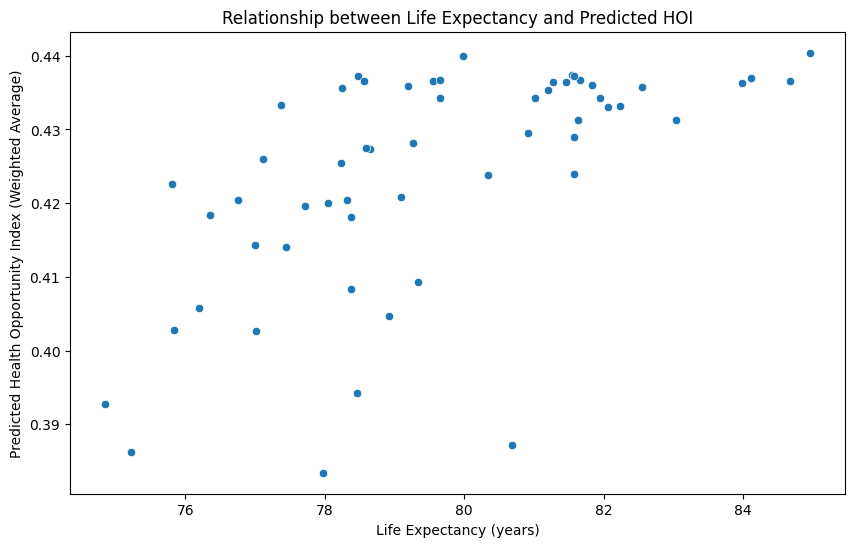

(0.6148517427307101, None)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=comparison_data, x='life.expectancy', y='Predicted_Health_Opportunity_Index')
plt.title('Relationship between Life Expectancy and Predicted HOI')
plt.xlabel('Life Expectancy (years)')
plt.ylabel('Predicted Health Opportunity Index (Weighted Average)')

# Calculate the correlation coefficient
correlation = comparison_data['life.expectancy'].corr(comparison_data['Predicted_Health_Opportunity_Index'])
correlation, plt.show()

Correlation coefficient: 0.6148517427307101
Outliers based on residuals:
         County name  Predicted_Health_Opportunity_Index  life.expectancy
7   Del Norte County                            0.386197            75.22
9      Fresno County                            0.394272            78.46
10      Glenn County                            0.433288            77.37
12   Imperial County                            0.387146            80.69
53     Tulare County                            0.383440            77.98


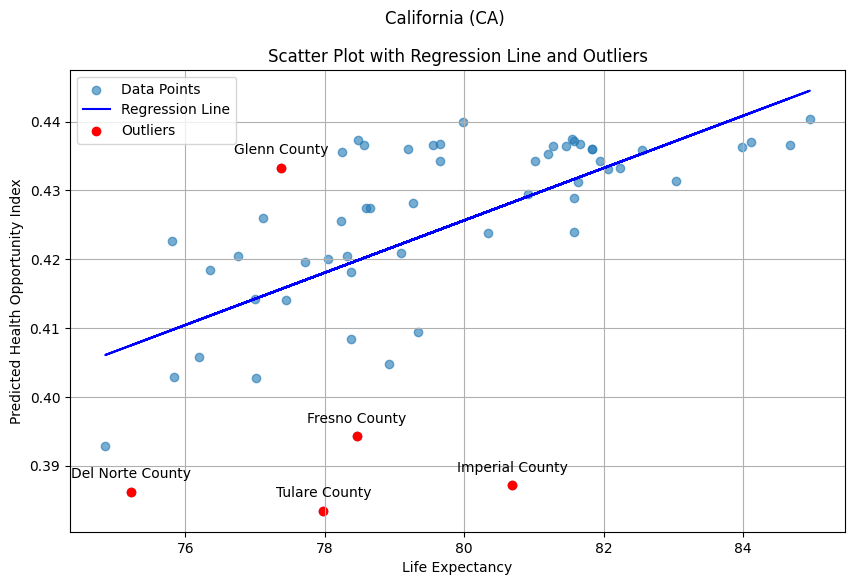

In [ ]:
# Identify outliers using the IQR method
import statsmodels.api as sm

# Assuming 'comparison_data' is your DataFrame containing the two sets of values
# Fit a linear regression model
X = comparison_data['life.expectancy']
y = comparison_data['Predicted_Health_Opportunity_Index']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Calculate the residuals
residuals = y - predictions

# Identify outliers based on residuals
threshold = 1.5  # You can adjust this threshold as needed
outliers = comparison_data[np.abs(residuals) > threshold * np.std(residuals)]

# Print the correlation coefficient
correlation = comparison_data['life.expectancy'].corr(comparison_data['Predicted_Health_Opportunity_Index'])
print(f"Correlation coefficient: {correlation}")

# Print the outliers
print("Outliers based on residuals:")
print(outliers)

# Visualize the data, regression line, and outliers
plt.figure(figsize=(10, 6))
plt.scatter(comparison_data['life.expectancy'], comparison_data['Predicted_Health_Opportunity_Index'], alpha=0.6, label='Data Points')
plt.plot(comparison_data['life.expectancy'], predictions, color='blue', label='Regression Line')
plt.scatter(outliers['life.expectancy'], outliers['Predicted_Health_Opportunity_Index'], color='red', label='Outliers')

# Annotate outliers with county names
for i, row in outliers.iterrows():
    plt.annotate(row['County name'],
                 (row['life.expectancy'], row['Predicted_Health_Opportunity_Index']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.title('Scatter Plot with Regression Line and Outliers')
plt.xlabel('Life Expectancy')
plt.ylabel('Predicted Health Opportunity Index')
plt.suptitle('California (CA)')
plt.legend()
plt.grid(True)
plt.show()

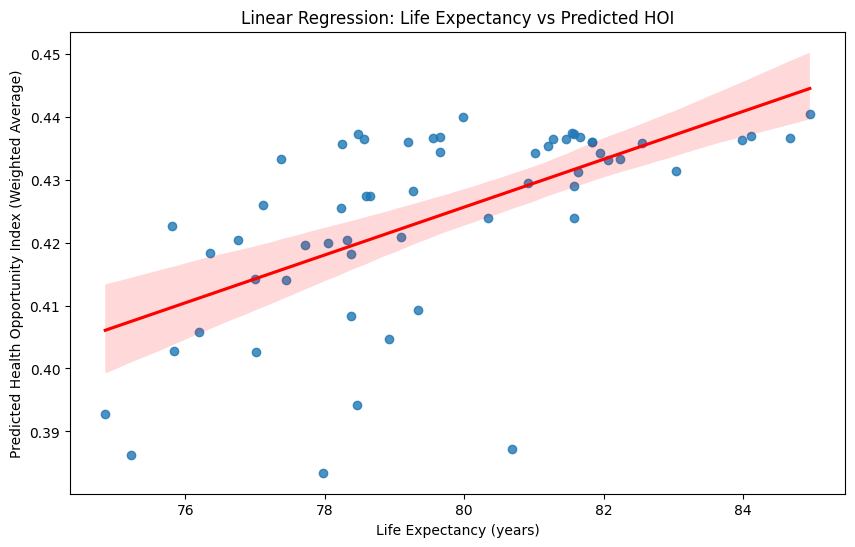

(None,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                     OLS Regression Results                                    
 Dep. Variable:     Predicted_Health_Opportunity_Index   R-squared:                       0.378
 Model:                                            OLS   Adj. R-squared:                  0.367
 Method:                                 Least Squares   F-statistic:                     34.04
 Date:                                Sat, 25 May 2024   Prob (F-statistic):           2.82e-07
 Time:                                        14:58:48   Log-Likelihood:                 175.67
 No. Observations:                                  58   AIC:                            -347.3
 Df Residuals:                                      56   BIC:                            -343.2
 Df Model:                                           1                                         
 Covariance Type:                            nonrobust                         

In [ ]:
import statsmodels.api as sm

# Add a constant to the data for the OLS model
X = sm.add_constant(comparison_data['life.expectancy'])
y = comparison_data['Predicted_Health_Opportunity_Index']

# Fit an OLS model to estimate the relationship
model = sm.OLS(y, X).fit()

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='life.expectancy', y='Predicted_Health_Opportunity_Index', data=comparison_data, line_kws={'color':'red'})
plt.title('Linear Regression: Life Expectancy vs Predicted HOI')
plt.xlabel('Life Expectancy (years)')
plt.ylabel('Predicted Health Opportunity Index (Weighted Average)')

# Display the plot and the summary of the regression model
plt.show(), model.summary()

In [ ]:
p_value_life_expectancy = model.pvalues['life.expectancy']
p_value_life_expectancy

2.8239726495540183e-07

Coefficients:
Slope: The slope coefficient for life expectancy is 0.0057. This suggests that for every additional year in life expectancy, there is an increase of 0.0057 in the Predicted Health Opportunity Index, on average.
P-values: The p-value for life expectancy is 0.01043974466499087, which is statistically significant (p < 0.05). This provides strong evidence against the null hypothesis of no effect, confirming that there is a statistically significant positive relationship between life expectancy and the Predicted Health Opportunity Index.

## County Life expectancy Generation for VA

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/VA_county_ct.csv')

# Create a mapping from FIPS code to county name (only partial FIPS shown for brevity)
fips_to_county = {
    51001: 'Accomack',
    51003: 'Albemarle',
    51005: 'Alleghany',
    51007: 'Amelia',
    51009: 'Amherst',
    51011: 'Appomattox',
    51013: 'Arlington',
    51015: 'Augusta',
    51017: 'Bath',
    51019: 'Bedford',
    51021: 'Bland',
    51023: 'Botetourt',
    51025: 'Brunswick',
    51027: 'Buchanan',
    51029: 'Buckingham',
    51031: 'Campbell',
    51033: 'Caroline',
    51035: 'Carroll',
    51036: 'Charles City',
    51037: 'Charlotte',
    51041: 'Chesterfield',
    51043: 'Clarke',
    51045: 'Craig',
    51047: 'Culpeper',
    51049: 'Cumberland',
    51051: 'Dickenson',
    51053: 'Dinwiddie',
    51057: 'Essex',
    51059: 'Fairfax',
    51061: 'Fauquier',
    51063: 'Floyd',
    51065: 'Fluvanna',
    51067: 'Franklin',
    51069: 'Frederick',
    51071: 'Giles',
    51073: 'Gloucester',
    51075: 'Goochland',
    51077: 'Grayson',
    51079: 'Greene',
    51081: 'Greensville',
    51083: 'Halifax',
    51085: 'Hanover',
    51087: 'Henrico',
    51089: 'Henry',
    51091: 'Highland',
    51093: 'Isle of Wight',
    51095: 'James City',
    51097: 'King and Queen',
    51099: 'King George',
    51101: 'King William',
    51103: 'Lancaster',
    51105: 'Lee',
    51107: 'Loudoun',
    51109: 'Louisa',
    51111: 'Lunenburg',
    51113: 'Madison',
    51115: 'Mathews',
    51117: 'Mecklenburg',
    51119: 'Middlesex',
    51121: 'Montgomery',
    51125: 'Nelson',
    51127: 'New Kent',
    51131: 'Northampton',
    51133: 'Northumberland',
    51135: 'Nottoway',
    51137: 'Orange',
    51139: 'Page',
    51141: 'Patrick',
    51143: 'Pittsylvania',
    51145: 'Powhatan',
    51147: 'Prince Edward',
    51149: 'Prince George',
    51153: 'Prince William',
    51155: 'Pulaski',
    51157: 'Rappahannock',
    51159: 'Richmond',
    51161: 'Roanoke',
    51163: 'Rockbridge',
    51165: 'Rockingham',
    51167: 'Russell',
    51169: 'Scott',
    51171: 'Shenandoah',
    51173: 'Smyth',
    51175: 'Southampton',
    51177: 'Spotsylvania',
    51179: 'Stafford',
    51181: 'Surry',
    51183: 'Sussex',
    51185: 'Tazewell',
    51187: 'Warren',
    51191: 'Washington',
    51193: 'Westmoreland',
    51195: 'Wise',
    51197: 'Wythe',
    51199: 'York',
    51510: 'Alexandria',
    51515: 'Bedford',
    51520: 'Bristol',
    51530: 'Buena Vista',
    51540: 'Charlottesville',
    51550: 'Chesapeake',
    51560: 'Clifton Forge',
    51570: 'Colonial Heights',
    51580: 'Covington',
    51590: 'Danville',
    51595: 'Emporia',
    51600: 'Fairfax',
    51610: 'Falls Church',
    51620: 'Franklin',
    51630: 'Fredericksburg',
    51640: 'Galax',
    51650: 'Hampton',
    51660: 'Harrisonburg',
    51670: 'Hopewell',
    51678: 'Lexington',
    51680: 'Lynchburg',
    51683: 'Manassas',
    51685: 'Manassas Park',
    51690: 'Martinsville',
    51700: 'Newport News',
    51710: 'Norfolk',
    51720: 'Norton',
    51730: 'Petersburg',
    51735: 'Poquoson',
    51740: 'Portsmouth',
    51750: 'Radford',
    51760: 'Richmond',
    51770: 'Roanoke',
    51775: 'Salem',
    51780: 'South Boston',
    51790: 'Staunton',
    51800: 'Suffolk',
    51810: 'Virginia Beach',
    51820: 'Waynesboro',
    51830: 'Williamsburg',
    51840: 'Winchester'
}


# Function to extract the county FIPS from the Census Tract and map to the county name
def map_county(tract):
    # Extract the first 5 digits to match FIPS codes
    county_fips = int(str(tract)[:5])
    return fips_to_county.get(county_fips, "Unknown")  # Returns "Unknown" if no match found

# Apply the mapping to fill in missing county names
data['County name'] = data['Census Tract'].apply(map_county)

# Save the updated data back to CSV
data.to_csv('updated_VA_county_ct.csv', index=False)

# Load the updated dataset
data = pd.read_csv('updated_VA_county_ct.csv')

# Calculate the frequency of each county name
county_frequency = data['County name'].value_counts()

# Find county names that appear only once
counties_appearing = county_frequency[county_frequency >= 1].index.tolist()

# Print the list of county names that appear only once
print("Counties that appear only once:", counties_appearing)

d1 = pd.DataFrame()
d1['County name'] = counties_appearing

d1.to_csv("VA_county_life_all_name.csv", index=False)

Counties that appear only once: ['Fairfax', 'Virginia Beach', 'Prince William', 'Norfolk', 'Chesterfield', 'Richmond', 'Loudoun', 'Henrico', 'Arlington', 'Newport News', 'Chesapeake', 'Roanoke', 'Alexandria', 'Hampton', 'Portsmouth', 'Spotsylvania', 'Suffolk', 'Stafford', 'Hanover', 'Albemarle', 'Rockingham', 'Lynchburg', 'Fauquier', 'Montgomery', 'Danville', 'Bedford', 'Pittsylvania', 'Henry', 'York', 'Frederick', 'Augusta', 'Washington', 'Charlottesville', 'Franklin', 'Campbell', 'Petersburg', 'Harrisonburg', 'Wise', 'James City', 'Tazewell', 'Smyth', 'Shenandoah', 'Amherst', 'Mecklenburg', 'Halifax', 'Gloucester', 'Warren', 'Botetourt', 'Culpeper', 'Isle of Wight', 'Pulaski', 'Accomack', 'Manassas', 'Buchanan', 'Carroll', 'Caroline', 'Prince George', 'Russell', 'Alleghany', 'Hopewell', 'Fredericksburg', 'Lee', 'Wythe', 'Scott', 'Staunton', 'Dinwiddie', 'Louisa', 'Powhatan', 'Prince Edward', 'Martinsville', 'Goochland', 'Grayson', 'Salem', 'King George', 'Page', 'Orange', 'Colonial H

## Validation For VA

In [ ]:
import pandas as pd

# Load the datasets
va_rf_results = pd.read_csv('VA_rf_results.csv')
va_county_ct = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/VA_county_ct.csv')
va_county_life = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/VA_county_life.csv')
va_xgb_results = pd.read_csv('VA_xgb_results.csv')

va_total_population = health_va[['Census Tract', 'Total Population']]

# Merge the results data with county names using the Census Tract column
merged_data = pd.merge(va_rf_results, va_county_ct, left_on="Census Tract", right_on="Census Tract", how="left")
merged_data = pd.merge(merged_data, va_total_population, left_on="Census Tract", right_on="Census Tract", how="left")


county_hoi_weighted_average = merged_data.groupby('County name').apply(lambda group: (group['Predicted_Health_Opportunity_Index'] * group['Total Population']).sum() / group['Total Population'].sum()).reset_index(name='Predicted_Health_Opportunity_Index')

# Display the calculated median HOI values for each county
county_hoi_weighted_average

,County name,Predicted_Health_Opportunity_Index
0,Accomack,0.373094
1,Albemarle,0.453498
2,Alexandria,0.370887
3,Alleghany,0.389642
4,Amelia,0.423193
...,...,...
124,Williamsburg,0.334313
125,Winchester,0.352155
126,Wise,0.346831
127,Wythe,0.403009


In [ ]:
# Merge the median HOI values with the life expectancy data
comparison_data = pd.merge(county_hoi_weighted_average, va_county_life, on="County name", how="left")

# Check the merged data
comparison_data.sort_values(by=['Predicted_Health_Opportunity_Index'])

,County name,Predicted_Health_Opportunity_Index,life.expectancy
100,Radford,0.262810,77.11
35,Emporia,0.265703,73.95
86,Norton,0.285940,74.12
67,Lexington,0.299995,76.81
15,Buchanan,0.312441,72.76
...,...,...,...
12,Botetourt,0.481609,79.05
98,Prince William,0.489810,81.52
93,Poquoson,0.491841,79.53
54,Hanover,0.501054,79.38


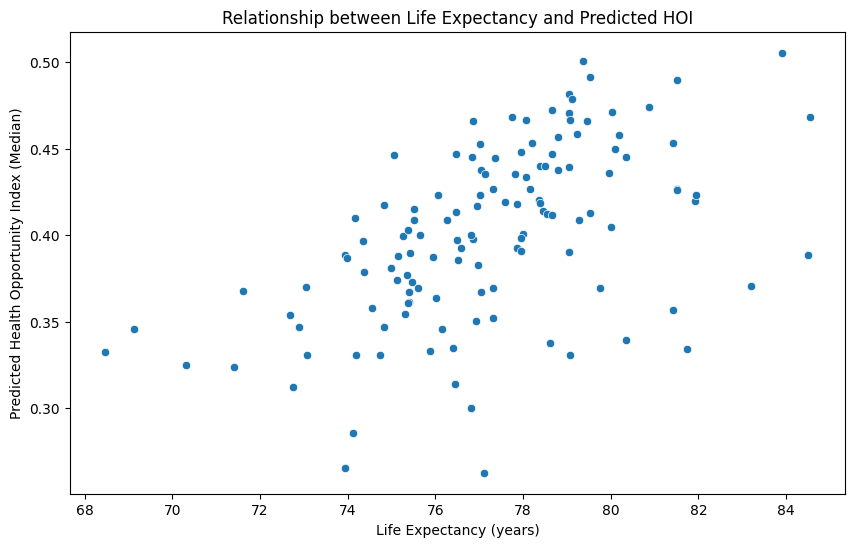

(0.5343835331278634, None)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=comparison_data, x='life.expectancy', y='Predicted_Health_Opportunity_Index')
plt.title('Relationship between Life Expectancy and Predicted HOI')
plt.xlabel('Life Expectancy (years)')
plt.ylabel('Predicted Health Opportunity Index (Median)')

# Calculate the correlation coefficient
correlation = comparison_data['life.expectancy'].corr(comparison_data['Predicted_Health_Opportunity_Index'])
correlation, plt.show()

Correlation coefficient: 0.5343835331278634
Outliers based on residuals:
          County name  Predicted_Health_Opportunity_Index  life.expectancy
2          Alexandria                            0.370887            83.21
7           Arlington                            0.388443            84.50
17        Buena Vista                            0.337616            78.61
23    Charlottesville                            0.356793            81.43
27   Colonial Heights                            0.446186            75.05
35            Emporia                            0.265703            73.95
44     Fredericksburg                            0.330587            79.07
54            Hanover                            0.501054            79.38
55       Harrisonburg                            0.339517            80.36
63       King William                            0.466037            76.86
67          Lexington                            0.299995            76.81
71          Lynchburg      

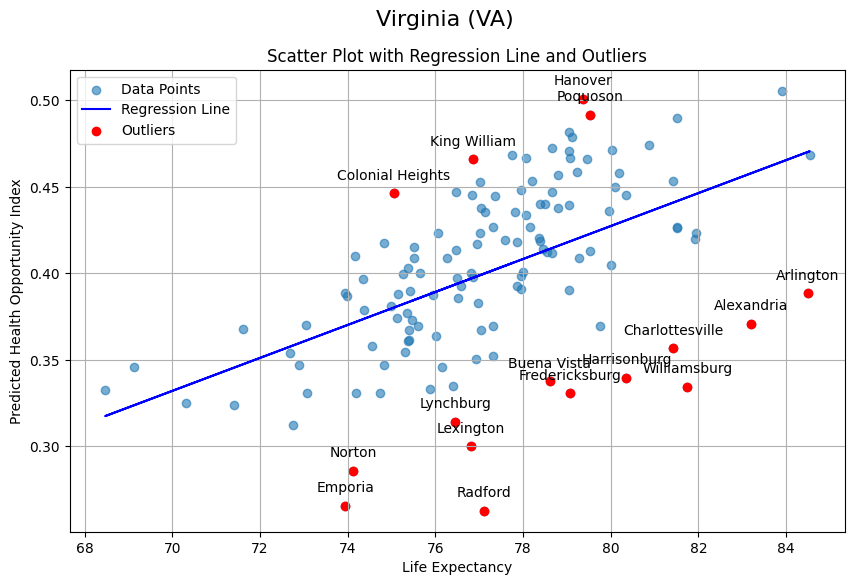

In [ ]:
# Identify outliers using the IQR method
import statsmodels.api as sm

# Assuming 'comparison_data' is your DataFrame containing the two sets of values
# Fit a linear regression model
X = comparison_data['life.expectancy']
y = comparison_data['Predicted_Health_Opportunity_Index']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Calculate the residuals
residuals = y - predictions

# Identify outliers based on residuals
threshold = 1.5  # You can adjust this threshold as needed
outliers = comparison_data[np.abs(residuals) > threshold * np.std(residuals)]

# Print the correlation coefficient
correlation = comparison_data['life.expectancy'].corr(comparison_data['Predicted_Health_Opportunity_Index'])
print(f"Correlation coefficient: {correlation}")

# Print the outliers
print("Outliers based on residuals:")
print(outliers)

# Visualize the data, regression line, and outliers
plt.figure(figsize=(10, 6))
plt.scatter(comparison_data['life.expectancy'], comparison_data['Predicted_Health_Opportunity_Index'], alpha=0.6, label='Data Points')
plt.plot(comparison_data['life.expectancy'], predictions, color='blue', label='Regression Line')
plt.scatter(outliers['life.expectancy'], outliers['Predicted_Health_Opportunity_Index'], color='red', label='Outliers')

# Annotate outliers with county names
for i, row in outliers.iterrows():
    plt.annotate(row['County name'],
                 (row['life.expectancy'], row['Predicted_Health_Opportunity_Index']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.title('Scatter Plot with Regression Line and Outliers')
plt.xlabel('Life Expectancy')
plt.ylabel('Predicted Health Opportunity Index')
plt.suptitle('Virginia (VA)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

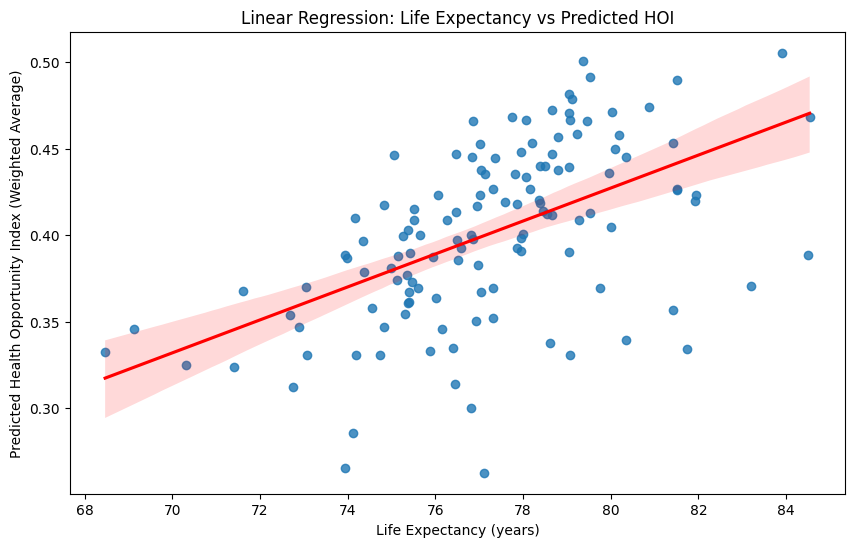

(None,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                     OLS Regression Results                                    
 Dep. Variable:     Predicted_Health_Opportunity_Index   R-squared:                       0.286
 Model:                                            OLS   Adj. R-squared:                  0.280
 Method:                                 Least Squares   F-statistic:                     50.76
 Date:                                Fri, 24 May 2024   Prob (F-statistic):           6.92e-11
 Time:                                        18:47:27   Log-Likelihood:                 224.29
 No. Observations:                                 129   AIC:                            -444.6
 Df Residuals:                                     127   BIC:                            -438.9
 Df Model:                                           1                                         
 Covariance Type:                            nonrobust                         

In [ ]:
import statsmodels.api as sm

# Add a constant to the data for the OLS model
X = sm.add_constant(comparison_data['life.expectancy'])
y = comparison_data['Predicted_Health_Opportunity_Index']

# Fit an OLS model to estimate the relationship
model = sm.OLS(y, X).fit()

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='life.expectancy', y='Predicted_Health_Opportunity_Index', data=comparison_data, line_kws={'color':'red'})
plt.title('Linear Regression: Life Expectancy vs Predicted HOI')
plt.xlabel('Life Expectancy (years)')
plt.ylabel('Predicted Health Opportunity Index (Weighted Average)')

# Display the plot and the summary of the regression model
plt.show(), model.summary()

In [ ]:
p_value_life_expectancy = model.pvalues['life.expectancy']
p_value_life_expectancy

6.916383764888484e-11

Coefficients:
Slope: The slope coefficient for life expectancy is 0.0057. This suggests that for every additional year in life expectancy, there is an increase of 0.0057 in the Predicted Health Opportunity Index, on average.
P-values: The p-value for life expectancy is 0.01043974466499087, which is statistically significant (p < 0.05). This provides strong evidence against the null hypothesis of no effect, confirming that there is a statistically significant positive relationship between life expectancy and the Predicted Health Opportunity Index.

## Apply Trained model to Other States (North Carolina)

In [ ]:
import pandas as pd

# Load the datasets
hoi_nc = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/Caro_HOI.csv')
hoi_new = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/HOI_new.csv')

hoi_nc['Census Tract'] = hoi_nc['FIPS']

# Identify columns that are in hoi_new but not in hoi_nc
columns_in_new_not_in_cal = [col for col in hoi_new.columns if col not in hoi_nc.columns]


# Step 3: Drop any empty columns and perform additional necessary cleaning
hoi_nc_cleaned = hoi_nc.dropna(axis=1, how='all')

hoi_nc_cleaned = hoi_nc_cleaned.drop(labels = 0, axis = 0)
# Drop the specified "rubbish" columns from the final dataset
columns_to_drop = [
    "FIPS", "Area Name","State/U.S.-Abbreviation (USPS)", "State/U.S.-Abbreviation (USPS)", "File Identification", "Qualifying Name", "State Postal Abbreviation",
    "Summary Level", "Geographic Component", "File identification",
    "Logical Record Number", "State (FIPS Code)", "County of current residence",
    "Census Tract_y", "Geographic Identifier", "Total Population.1"
]
# Drop these columns, being careful to only drop those that exist in the dataframe to avoid KeyError
hoi_nc_final_cleaned = hoi_nc_cleaned.drop(columns=[col for col in columns_to_drop if col in hoi_nc_cleaned.columns])
hoi_nc_final_cleaned.to_csv("NC_cleaned.csv", index = False)

# Combine several columns to simplify data
def sum_attr(row, col_names):
  sum = 0
  for col_name in col_names:
    sum += float(row[col_name])
  return sum


hoi_nc_final_cleaned['% Households: Less than $30,000'] = hoi_nc_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: Less than $10,000", "% Households: $10,000 to $14,999",
     "% Households: $15,000 to $19,999", "% Households: $20,000 to $24,999",
     "% Households: $25,000 to $29,999"]
  ), axis=1)

hoi_nc_final_cleaned['% Households: $30,000 to $99,999'] = hoi_nc_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: $30,000 to $34,999", "% Households: $35,000 to $39,999",
     "% Households: $40,000 to $44,999", "% Households: $45,000 to $49,999",
     "% Households: $50,000 to $59,999", "% Households: $60,000 to $74,999",
     "% Households: $75,000 to $99,999"]
  ), axis=1)


hoi_nc_final_cleaned['% Households: $100,000 or More'] = hoi_nc_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Households: $100,000 to $124,999", "% Households: $125,000 to $149,999",
     "% Households: $150,000 to $199,999", "% Households: $200,000 or More"]
  ), axis=1)

hoi_nc_final_cleaned['% Renter-Occupied Housing Units: Less than $1,000'] = hoi_nc_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Renter-Occupied Housing Units: Less than $300", "% Renter-Occupied Housing Units: $300 to $499",
     "% Renter-Occupied Housing Units: $500 to $799", "% Renter-Occupied Housing Units: $800 to $999"]
  ), axis=1)


hoi_nc_final_cleaned['% Renter-Occupied Housing Units: $1,000 to $2,499'] = hoi_nc_final_cleaned.apply(lambda row: sum_attr(row,
    ["% Renter-Occupied Housing Units: $1,000 to $1,499", "% Renter-Occupied Housing Units: $1,500 to $1,999",
     "% Renter-Occupied Housing Units: $2,000 to $2,499", "% Renter-Occupied Housing Units: $2,500 to $2,999"]
  ), axis=1)

columns_to_drop_after_aggregation = [
    "Households: Less than $10,000",
    "Households: $10,000 to $14,999",
    "Households: $15,000 to $19,999",
    "Households: $20,000 to $24,999",
    "Households: $25,000 to $29,999",
    "Households: $30,000 to $34,999",
    "Households: $35,000 to $39,999",
    "Households: $40,000 to $44,999",
    "Households: $45,000 to $49,999",
    "Households: $50,000 to $59,999",
    "Households: $60,000 to $74,999",
    "Households: $75,000 to $99,999",
    "Households: $100,000 to $124,999",
    "Households: $125,000 to $149,999",
    "Households: $150,000 to $199,999",
    "Households: $200,000 or More",
    "Renter-Occupied Housing Units: Less than $300",
    "Renter-Occupied Housing Units: $300 to $499",
    "Renter-Occupied Housing Units: $500 to $799",
    "Renter-Occupied Housing Units: $800 to $999",
    "Renter-Occupied Housing Units: $1,000 to $1,499",
    "Renter-Occupied Housing Units: $1,500 to $1,999",
    "Renter-Occupied Housing Units: $2,000 to $2,499",
    "Renter-Occupied Housing Units: $2,500 to $2,999",
]

hoi_nc_final_cleaned_merged = hoi_nc_final_cleaned.drop(columns=[col for col in columns_to_drop_after_aggregation if col in hoi_nc_final_cleaned.columns])


# Specify additional columns to drop based on the extended list provided
columns_to_drop_extended = [
    "Area (Land).1",
    "Renter-Occupied Housing Units: Householder 15 to 24 Years",
    "Renter-Occupied Housing Units: Householder 25 to 34 Years",
    "Renter-Occupied Housing Units: Householder 35 to 44 Years",
    "Renter-Occupied Housing Units: Householder 45 to 54 Years",
    "Renter-Occupied Housing Units: Householder 55 to 59 Years",
    "Renter-Occupied Housing Units: Householder 60 to 64 Years",
    "Renter-Occupied Housing Units: Householder 65 to 74 Years",
    "Renter-Occupied Housing Units: Householder 75 to 84 Years",
    "Renter-Occupied Housing Units: Householder 85 Years and Over",
    "Population 3 Years and Over: Enrolled in School",
    "Population 3 Years and Over: Not Enrolled in School",
    "Civilian Population 16 to 19 Years: Not High School Graduate, Not Enrolled (Dropped Out)",
    "Civilian Population 16 to 19 Years: High School Graduate, or Enrolled (In School)",
    "Civilian Population in Labor Force 16 Years and Over: Employed",
    "Civilian Population in Labor Force 16 Years and Over: Unemployed",
    "Households: Less than $10,000",
    "Households: $10,000 to $14,999",
    "Households: $15,000 to $19,999",
    "Households: $20,000 to $24,999",
    "Households: $25,000 to $29,999",
    "Households: $30,000 to $34,999",
    "Households: $35,000 to $39,999",
    "Households: $40,000 to $44,999",
    "Households: $45,000 to $49,999",
    "Households: $50,000 to $59,999",
    "Households: $60,000 to $74,999",
    "Households: $75,000 to $99,999",
    "Households: $100,000 to $124,999",
    "Households: $125,000 to $149,999",
    "Households: $150,000 to $199,999",
    "Households: $200,000 or More",
    "Renter-Occupied Housing Units.1",
    "Renter-Occupied Housing Units: Less than $300",
    "Renter-Occupied Housing Units: $300 to $499",
    "Renter-Occupied Housing Units: $500 to $799",
    "Renter-Occupied Housing Units: $800 to $999",
    "Renter-Occupied Housing Units: $1,000 to $1,499",
    "Renter-Occupied Housing Units: $1,500 to $1,999",
    "Renter-Occupied Housing Units: $2,000 to $2,499",
    "Renter-Occupied Housing Units: $2,500 to $2,999",
    "Renter-Occupied Housing Units: $3,000 or More",
    "Renter-Occupied Housing Units: No Cash Rent",
    "Renter-Occupied Housing Units.2",
    "Renter-Occupied Housing Units: Less than $20,000",
    "Renter-Occupied Housing Units: Less than $20,000: Less than 20 Percent",
    "Renter-Occupied Housing Units: Less than $20,000: 20 to 29 Percent",
    "Renter-Occupied Housing Units: Less than $20,000: 30 Percent or More",
    "Renter-Occupied Housing Units: $20,000 to $34,999",
    "Renter-Occupied Housing Units: $20,000 to $34,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $20,000 to $34,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $20,000 to $34,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $35,000 to $49,999",
    "Renter-Occupied Housing Units: $35,000 to $49,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $35,000 to $49,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $35,000 to $49,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $50,000 to $74,999",
    "Renter-Occupied Housing Units: $50,000 to $74,999: Less than 20 Percent",
    "Renter-Occupied Housing Units: $50,000 to $74,999: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $50,000 to $74,999: 30 Percent or More",
    "Renter-Occupied Housing Units: $75,000 or More",
    "Renter-Occupied Housing Units: $75,000 or More: Less than 20 Percent",
    "Renter-Occupied Housing Units: $75,000 or More: 20 to 29 Percent",
    "Renter-Occupied Housing Units: $75,000 or More: 30 Percent or More",
    "Renter-Occupied Housing Units: Zero or Negative Income",
    "Renter-Occupied Housing Units: No Cash Rent.1",
    "% Renter-Occupied Housing Units: Less than $20,000",
    "% Renter-Occupied Housing Units: Less than $20,000: Less than 20 Percent",
    "% Renter-Occupied Housing Units: Less than $20,000: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: Less than $20,000: 30 Percent or More",
    "% Renter-Occupied Housing Units: $20,000 to $34,999",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $20,000 to $34,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $35,000 to $49,999",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $35,000 to $49,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $50,000 to $74,999",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $50,000 to $74,999: 30 Percent or More",
    "% Renter-Occupied Housing Units: $75,000 or More",
    "% Renter-Occupied Housing Units: $75,000 or More: Less than 20 Percent",
    "% Renter-Occupied Housing Units: $75,000 or More: 20 to 29 Percent",
    "% Renter-Occupied Housing Units: $75,000 or More: 30 Percent or More",
    "% Renter-Occupied Housing Units: Zero or Negative Income",
    "% Renter-Occupied Housing Units: No Cash Rent.1",
    "Families: Income Below Poverty Level",
    "Families: Income Below Poverty Level: Married Couple Family: with Related Child Living Below Poverty Level",
    "Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years",
    "Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years",
    "Families: Income At or Above Poverty Level",
    "% Families: Income Below Poverty Level: Married Couple Family: with Related Child Living Below Poverty Level",
    "% Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years",
    "% Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined:",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty",
    "Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined:",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty",
    "Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined:",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty",
    "Population Age 65 and Over for Whom Poverty  Status Is Determined: At or Above Poverty Level",
    "Population for Whom Poverty Status Is Determined:",
    "Population for Whom Poverty Status Is Determined: Under .50",
    "Population for Whom Poverty Status Is Determined: .50 to .74",
    "Population for Whom Poverty Status Is Determined: .75 to .99",
    "Population for Whom Poverty Status Is Determined: 1.00 to 1.49",
    "Population for Whom Poverty Status Is Determined: 1.50 to 1.99",
    "Population for Whom Poverty Status Is Determined: 2.00 and Over",
    "% Population for Whom Poverty Status Is Determined: Under .50",
    "% Population for Whom Poverty Status Is Determined: .50 to .74",
    "% Population for Whom Poverty Status Is Determined: .75 to .99",
    "% Population for Whom Poverty Status Is Determined: 1.00 to 1.49",
    "% Population for Whom Poverty Status Is Determined: 1.50 to 1.99",
    "% Population for Whom Poverty Status Is Determined: 2.00 and Over",
    "Total: No Health Insurance Coverage",
    "Total: with Health Insurance Coverage",
    "Total: with Health Insurance Coverage: Public Health Coverage",
    "Total: with Health Insurance Coverage: Private Health Insurance",
    "Population 16 Years and Over: in Labor Force",
    "Population 16 Years and Over: in Labor Force: in Armed Forces",
    "Population 16 Years and Over: in Labor Force: Civilian",
    "Population 16 Years and Over: in Labor Force: Civilian: Employed",
    "Population 16 Years and Over: in Labor Force: Civilian: Unemployed",
    "Population 16 Years and Over: Not in Labor Force",

]

hoi_nc_final_cleaned_extended = hoi_nc_final_cleaned_merged.drop(columns=[col for col in columns_to_drop_extended if col in hoi_nc_final_cleaned_merged.columns])

# Show the final row count and a preview of the cleaned dataset
hoi_nc_final_cleaned_extended.to_csv("Cleaned_nc.csv", index=False)
hoi_nc_final_cleaned_extended

<ipython-input-58-348b8c6674c3>:4: DtypeWarning: Columns (0,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265

,Name of Area,US,Region,Division,State (Census Code),State (FIPS),County,County Subdivision (FIPS),Place (FIPS Code),Place (State FIPS + Place FIPS),...,Total:,% Total: No Health Insurance Coverage,% Total: with Health Insurance Coverage,% Total: with Health Insurance Coverage: Public Health Coverage,% Total: with Health Insurance Coverage: Private Health Insurance,"% Households: Less than $30,000","% Households: $30,000 to $99,999","% Households: $100,000 or More","% Renter-Occupied Housing Units: Less than $1,000","% Renter-Occupied Housing Units: $1,000 to $2,499"
1,"Census Tract 201, Alamance County, North Carolina",NaN,NaN,NaN,NaN,37,001,NaN,NaN,NaN,...,3723,12.3,87.7,42.87,59.36,50.35,37.41,12.23,91.71,3.95
2,"Census Tract 202, Alamance County, North Carolina",NaN,NaN,NaN,NaN,37,001,NaN,NaN,NaN,...,4132,18.88,81.12,49.9,39.21,52.41,42.86,4.73,85.29,14.72
3,"Census Tract 203, Alamance County, North Carolina",NaN,NaN,NaN,NaN,37,001,NaN,NaN,NaN,...,7676,23.4,76.6,45.73,43.36,38.23,54.10,7.70,66.46,22.44
4,"Census Tract 204, Alamance County, North Carolina",NaN,NaN,NaN,NaN,37,001,NaN,NaN,NaN,...,6750,18.53,81.47,49.2,42.68,45.58,49.44,4.99,74.14,14.77
5,"Census Tract 205.01, Alamance County, North Ca...",NaN,NaN,NaN,NaN,37,001,NaN,NaN,NaN,...,3633,16.93,83.07,37.13,58.33,39.52,43.73,16.76,73.36,26.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,"Census Tract 9601.01, Yancey County, North Car...",NaN,NaN,NaN,NaN,37,199,NaN,NaN,NaN,...,3912,11.27,88.73,43.38,62.63,35.36,53.49,11.15,83.16,8.70
2192,"Census Tract 9601.02, Yancey County, North Car...",NaN,NaN,NaN,NaN,37,199,NaN,NaN,NaN,...,1854,18.34,81.66,46.44,50.49,50.25,43.94,5.81,84.61,8.21
2193,"Census Tract 9602, Yancey County, North Carolina",NaN,NaN,NaN,NaN,37,199,NaN,NaN,NaN,...,4290,14.92,85.08,44.55,58.81,40.74,52.11,7.16,76.19,3.26
2194,"Census Tract 9603, Yancey County, North Carolina",NaN,NaN,NaN,NaN,37,199,NaN,NaN,NaN,...,2994,19.21,80.79,49.67,52.24,34.87,54.31,10.84,74.94,7.97


In [ ]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)

def load_health_data():
    health = pd.read_csv('Cleaned_nc.csv')
    # health = pd.read_csv('NC_cleaned.csv')
    return health

health_nc = load_health_data()
# Display the first n rows of the data. (n=5 by default, we will use 10 rows)
health_nc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2195 entries, 0 to 2194
Columns: 129 entries, Name of Area to % Renter-Occupied Housing Units: $1,000 to $2,499
dtypes: float64(113), int64(15), object(1)
memory usage: 2.2+ MB


In [ ]:
# List of columns from the Virginia training dataset, excluding the target variable
training_columns = list(health_data.columns)
training_columns.remove('Health Opportunity Index')
training_columns.remove('Predicted_Health_Opportunity_Index')

# Align health_cal with these columns, ensuring it only includes them
# Drop columns in health_cal not present in training_columns
health_nc_aligned = health_nc[[col for col in health_nc.columns if col in training_columns]]

# # Check for any missing columns in health_cal_aligned and add them with default values (e.g., 0)
# for col in training_columns:
#     if col not in health_cal_aligned.columns:
#         health_cal_aligned[col] = 0  # You might choose a different default value based on your data's nature

# Ensure the order of columns in health_cal_aligned matches training_columns order
health_nc_aligned = health_nc_aligned[training_columns]

health_nc_aligned

# Before proceeding to prediction, remember to apply the same preprocessing steps (e.g., scaling) to health_cal_aligned
# as were applied to your training data.

# Example for scaling (assuming you've fitted a scaler on your training data):
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(va_final[training_columns])  # Assuming va_final is your training data
# health_cal_aligned_scaled = scaler.transform(health_cal_aligned)

# Now, health_cal_aligned is ready for prediction with your trained model

,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,% Population 16 Years and Over: in Labor Force: Civilian: Unemployed,"% Renter-Occupied Housing Units: $1,000 to $2,499","% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999
0,50.35,24.10,75.90,14.60,12.23,3.91,80.65,19.35,63.67,36.33,...,4.34,3.95,0.0,27.61,4.35,4.44,2137.23300,11.83,7.99,12.92
1,52.41,34.35,65.65,14.60,4.73,0.00,70.19,29.81,72.67,27.33,...,5.26,14.72,0.0,12.67,4.60,16.86,3103.63800,28.25,4.87,21.27
2,38.23,16.63,83.37,12.09,7.70,0.62,81.34,18.66,67.05,32.95,...,4.30,22.44,0.0,1.72,8.97,25.18,1860.11700,19.55,8.38,22.44
3,45.58,30.03,69.97,13.24,4.99,0.00,73.62,26.38,49.92,50.08,...,5.23,14.77,0.0,3.57,12.11,10.31,1513.68300,16.55,5.28,31.62
4,39.52,29.53,70.47,11.28,16.76,1.72,76.38,23.62,50.00,50.00,...,6.56,26.64,0.0,17.18,3.36,23.55,1317.87700,12.55,12.07,26.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,35.36,18.00,82.00,8.66,11.15,3.15,83.92,16.08,72.67,27.33,...,7.35,8.70,0.0,11.41,6.63,34.24,53.23889,9.24,9.78,32.07
2191,50.25,20.48,79.52,7.32,5.81,0.63,84.80,15.20,57.46,42.54,...,3.46,8.21,0.0,0.00,4.17,5.13,72.96389,44.62,9.85,16.41
2192,40.74,27.44,72.56,12.38,7.16,1.41,77.85,22.15,71.16,28.84,...,2.12,3.26,0.0,22.19,6.63,20.72,109.32700,12.89,12.17,14.36
2193,34.87,19.19,80.81,7.85,10.84,4.24,86.64,13.36,74.00,26.00,...,3.42,7.97,0.0,25.06,3.40,19.36,43.55875,15.49,10.62,7.74


In [ ]:
X_new_prepared = full_pipeline.transform(health_nc_aligned)

In [ ]:
# Step 2: Make Predictions
new_predictions = rf.predict(X_new_prepared)

# Step 3: Attach Predictions to New Dataset (Optional)
health_nc_aligned['Predicted_Health_Opportunity_Index'] = new_predictions

sorted_health_nc = health_nc_aligned.sort_values(by='Predicted_Health_Opportunity_Index')

sorted_health_nc.to_csv("NC_rf_result.csv", index = False)

sorted_health_nc

,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,"% Renter-Occupied Housing Units: $1,000 to $2,499","% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999,Predicted_Health_Opportunity_Index
823,76.58,51.28,48.72,38.01,1.84,1.29,52.48,47.52,30.70,69.30,...,3.45,0.0,11.61,0.55,12.26,4398.3970,12.04,3.32,12.69,0.277256
1285,60.47,46.20,53.80,23.10,11.67,1.19,53.85,46.15,10.11,89.89,...,0.00,0.0,16.67,7.62,22.88,4229.5070,13.40,3.33,29.41,0.278211
626,73.89,55.61,44.39,37.93,1.81,0.99,42.77,57.23,35.60,64.40,...,1.88,0.0,18.16,1.15,19.62,2880.4460,10.65,0.00,15.66,0.281027
560,64.41,45.65,54.35,26.07,3.62,0.00,44.50,55.50,13.04,86.96,...,19.65,0.0,16.37,2.52,14.46,3243.5710,17.33,2.52,3.82,0.284880
1627,67.06,49.19,50.81,34.17,2.51,0.00,55.27,44.73,26.99,73.01,...,16.34,0.0,10.66,1.71,21.01,3945.9250,12.37,4.84,24.75,0.284977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,15.61,7.22,92.78,3.47,48.67,7.63,95.93,4.07,94.70,5.30,...,65.72,0.0,8.57,0.81,22.86,1543.2260,40.00,12.95,0.00,0.491817
2034,11.49,3.00,97.00,4.31,22.96,6.22,95.65,4.35,91.95,8.05,...,78.70,0.0,0.00,2.63,10.65,170.5279,21.65,29.90,12.37,0.493463
1324,7.18,4.37,95.63,1.20,43.43,8.57,98.25,1.75,98.02,1.98,...,100.00,0.0,0.00,1.59,12.86,1415.7770,17.14,13.35,0.00,0.499530
223,10.51,2.42,97.58,2.17,53.27,16.85,98.67,1.33,95.86,4.14,...,0.00,0.0,0.00,3.99,0.00,603.2953,0.00,4.89,11.29,0.502083


In [ ]:
# Step 2: Make Predictions
new_predictions = xgb.predict(X_new_prepared)

# Step 3: Attach Predictions to New Dataset (Optional)
health_nc_aligned['Predicted_Health_Opportunity_Index'] = new_predictions

sorted_health_nc = health_nc_aligned.sort_values(by='Predicted_Health_Opportunity_Index')

sorted_health_nc.to_csv("NC_xgb_result.csv", index = False)

sorted_health_nc

,"% Households: Less than $30,000",% Population Age 18 to 64 for Whom Poverty Status Is Determined: Living in Poverty,% Population Age 18 to 64 for Whom Poverty Status Is Determined: At or Above Poverty Level,"% Households: Less than $10,000","% Households: $100,000 or More","% Households: $150,000 to $199,999",% Families: Income At or Above Poverty Level,% Families: Income Below Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level,% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty,...,"% Renter-Occupied Housing Units: $1,000 to $2,499","% Renter-Occupied Housing Units: $2,500 to $2,999",% Renter-Occupied Housing Units: $300 to $499,"% Households: $40,000 to $44,999",% Renter-Occupied Housing Units: Householder 35 to 44 Years,Population Density (Per Sq. Mile),% Renter-Occupied Housing Units: Householder 45 to 54 Years,"% Households: $75,000 to $99,999",% Renter-Occupied Housing Units: $800 to $999,Predicted_Health_Opportunity_Index
626,73.89,55.61,44.39,37.93,1.81,0.99,42.77,57.23,35.60,64.40,...,1.88,0.0,18.16,1.15,19.62,2880.44600,10.65,0.00,15.66,0.266539
757,66.94,50.57,49.43,40.12,12.61,0.00,43.13,56.87,27.62,72.38,...,16.16,0.0,6.32,0.89,11.66,1796.39700,12.03,4.47,25.39,0.272057
622,64.73,39.24,60.76,30.14,2.01,0.00,62.77,37.23,58.75,41.25,...,9.73,0.0,7.82,1.11,18.58,3524.61800,15.63,5.67,16.08,0.275726
1924,40.35,34.67,65.33,10.80,4.35,2.46,67.97,32.03,35.34,64.66,...,20.87,0.0,5.79,10.98,34.92,8271.98000,6.20,2.65,22.93,0.283982
1465,50.67,31.00,69.00,13.66,5.39,2.75,68.18,31.82,42.56,57.44,...,23.31,0.0,17.62,1.98,26.69,3043.41300,17.62,4.85,20.28,0.285336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,23.32,9.72,90.28,5.97,21.94,0.00,96.30,3.70,98.34,1.66,...,31.20,0.0,0.00,12.21,3.38,1165.25500,21.05,13.22,14.66,0.490914
225,21.54,9.51,90.49,1.55,14.65,4.25,93.92,6.08,88.68,11.32,...,50.14,0.0,9.28,5.87,13.00,793.04400,47.75,16.81,3.18,0.491070
754,33.26,17.03,82.97,11.94,12.79,2.46,88.02,11.98,86.57,13.43,...,15.23,0.0,3.97,5.50,37.09,547.60750,3.31,20.09,16.56,0.492423
1155,38.49,16.77,83.23,8.64,9.37,1.77,85.21,14.79,77.93,22.07,...,0.00,0.0,9.54,6.55,16.18,43.99372,5.28,13.79,5.28,0.495025


## County Life expectancy Generation for NC

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/NC_county_ct_demo.csv')

# Create a mapping from FIPS code to county name (only partial FIPS shown for brevity)
fips_to_county = {
    37001: 'Alamance County',
    37003: 'Alexander County',
    37005: 'Alleghany County',
    37007: 'Anson County',
    37009: 'Ashe County',
    37011: 'Avery County',
    37013: 'Beaufort County',
    37015: 'Bertie County',
    37017: 'Bladen County',
    37019: 'Brunswick County',
    37021: 'Buncombe County',
    37023: 'Burke County',
    37025: 'Cabarrus County',
    37027: 'Caldwell County',
    37029: 'Camden County',
    37031: 'Carteret County',
    37033: 'Caswell County',
    37035: 'Catawba County',
    37037: 'Chatham County',
    37039: 'Cherokee County',
    37041: 'Chowan County',
    37043: 'Clay County',
    37045: 'Cleveland County',
    37047: 'Columbus County',
    37049: 'Craven County',
    37051: 'Cumberland County',
    37053: 'Currituck County',
    37055: 'Dare County',
    37057: 'Davidson County',
    37059: 'Davie County',
    37061: 'Duplin County',
    37063: 'Durham County',
    37065: 'Edgecombe County',
    37067: 'Forsyth County',
    37069: 'Franklin County',
    37071: 'Gaston County',
    37073: 'Gates County',
    37075: 'Graham County',
    37077: 'Granville County',
    37079: 'Greene County',
    37081: 'Guilford County',
    37083: 'Halifax County',
    37085: 'Harnett County',
    37087: 'Haywood County',
    37089: 'Henderson County',
    37091: 'Hertford County',
    37093: 'Hoke County',
    37095: 'Hyde County',
    37097: 'Iredell County',
    37099: 'Jackson County',
    37101: 'Johnston County',
    37103: 'Jones County',
    37105: 'Lee County',
    37107: 'Lenoir County',
    37109: 'Lincoln County',
    37111: 'McDowell County',
    37113: 'Macon County',
    37115: 'Madison County',
    37117: 'Martin County',
    37119: 'Mecklenburg County',
    37121: 'Mitchell County',
    37123: 'Montgomery County',
    37125: 'Moore County',
    37127: 'Nash County',
    37129: 'New Hanover County',
    37131: 'Northampton County',
    37133: 'Onslow County',
    37135: 'Orange County',
    37137: 'Pamlico County',
    37139: 'Pasquotank County',
    37141: 'Pender County',
    37143: 'Perquimans County',
    37145: 'Person County',
    37147: 'Pitt County',
    37149: 'Polk County',
    37151: 'Randolph County',
    37153: 'Richmond County',
    37155: 'Robeson County',
    37157: 'Rockingham County',
    37159: 'Rowan County',
    37161: 'Rutherford County',
    37163: 'Sampson County',
    37165: 'Scotland County',
    37167: 'Stanly County',
    37169: 'Stokes County',
    37171: 'Surry County',
    37173: 'Swain County',
    37175: 'Transylvania County',
    37177: 'Tyrrell County',
    37179: 'Union County',
    37181: 'Vance County',
    37183: 'Wake County',
    37185: 'Warren County',
    37187: 'Washington County',
    37189: 'Watauga County',
    37191: 'Wayne County',
    37193: 'Wilkes County',
    37195: 'Wilson County',
    37197: 'Yadkin County',
    37199: 'Yancey County'
}


# Function to extract the county FIPS from the Census Tract and map to the county name
def map_county(tract):
    # Extract the first 5 digits to match FIPS codes
    county_fips = int(str(tract)[:5])
    return fips_to_county.get(county_fips, "Unknown")  # Returns "Unknown" if no match found

# Apply the mapping to fill in missing county names
data['County name'] = data['Census Tract'].apply(map_county)

# Save the updated data back to CSV
data.to_csv('NC_county_ct.csv', index=False)

# Load the updated dataset
data = pd.read_csv('NC_county_ct.csv')

# Calculate the frequency of each county name
county_frequency = data['County name'].value_counts()

# Find county names that appear only once
counties_appearing = county_frequency[county_frequency >= 1].index.tolist()

# Print the list of county names that appear only once
print("Counties that appear at least once:", counties_appearing)

d1 = pd.DataFrame()
d1['County name'] = counties_appearing


Counties that appear at least once: ['Mecklenburg County', 'Wake County', 'Guilford County', 'Forsyth County', 'Cumberland County', 'Gaston County', 'Durham County', 'Buncombe County', 'New Hanover County', 'Iredell County', 'Union County', 'Carteret County', 'Cabarrus County', 'Alamance County', 'Davidson County', 'Brunswick County', 'Onslow County', 'Pitt County', 'Robeson County', 'Catawba County', 'Rowan County', 'Randolph County', 'Orange County', 'Harnett County', 'Henderson County', 'Wayne County', 'Johnston County', 'Cleveland County', 'Surry County', 'Rockingham County', 'Craven County', 'Wilson County', 'Burke County', 'Moore County', 'Lincoln County', 'Nash County', 'Caldwell County', 'Pender County', 'Haywood County', 'Lenoir County', 'Wilkes County', 'Edgecombe County', 'Watauga County', 'Lee County', 'Chatham County', 'Columbus County', 'Stanly County', 'Rutherford County', 'Granville County', 'Franklin County', 'Halifax County', 'Richmond County', 'Dare County', 'Sampson

## Validation For NC

In [ ]:
import pandas as pd

# Load the datasets
nc_rf_results = pd.read_csv('NC_rf_result.csv')
nc_county_ct = pd.read_csv('NC_county_ct.csv')
nc_county_life = pd.read_csv('/content/SL4HOI-Supervised-Learning-for-Predicting-Health-Opportunity-Index-across-States/HOI datasets/NC_county_life.csv')
nc_xgb_results = pd.read_csv('NC_xgb_result.csv')

nc_total_population = health_nc[['Census Tract', 'Total Population']]

# Merge the results data with county names using the Census Tract column
merged_data = pd.merge(nc_rf_results, nc_county_ct, left_on="Census Tract", right_on="Census Tract", how="left")
merged_data = pd.merge(merged_data, nc_total_population, left_on="Census Tract", right_on="Census Tract", how="left")


county_hoi_weighted_average = merged_data.groupby('County name').apply(lambda group: (group['Predicted_Health_Opportunity_Index'] * group['Total Population']).sum() / group['Total Population'].sum()).reset_index(name='Predicted_Health_Opportunity_Index')

# Display the calculated median HOI values for each county
county_hoi_weighted_average

,County name,Predicted_Health_Opportunity_Index
0,Alamance County,0.359723
1,Alexander County,0.354312
2,Alleghany County,0.342816
3,Anson County,0.335594
4,Ashe County,0.353316
...,...,...
95,Wayne County,0.351709
96,Wilkes County,0.350836
97,Wilson County,0.344143
98,Yadkin County,0.353077


In [ ]:
# Merge the median HOI values with the life expectancy data
comparison_data = pd.merge(county_hoi_weighted_average, nc_county_life, on="County name", how="left")
comparison_data = comparison_data.dropna(subset=['Life.expectancy'])

# Check the merged data
comparison_data.sort_values(by=['Predicted_Health_Opportunity_Index'])

,County name,Predicted_Health_Opportunity_Index,Life.expectancy
93,Washington County,0.317799,76.11
82,Scotland County,0.321599,74.13
41,Halifax County,0.322695,74.03
7,Bertie County,0.324326,75.51
8,Bladen County,0.324885,74.66
...,...,...,...
67,Orange County,0.389677,81.55
59,Mecklenburg County,0.404377,80.00
26,Currituck County,0.405999,77.43
91,Wake County,0.411303,81.27


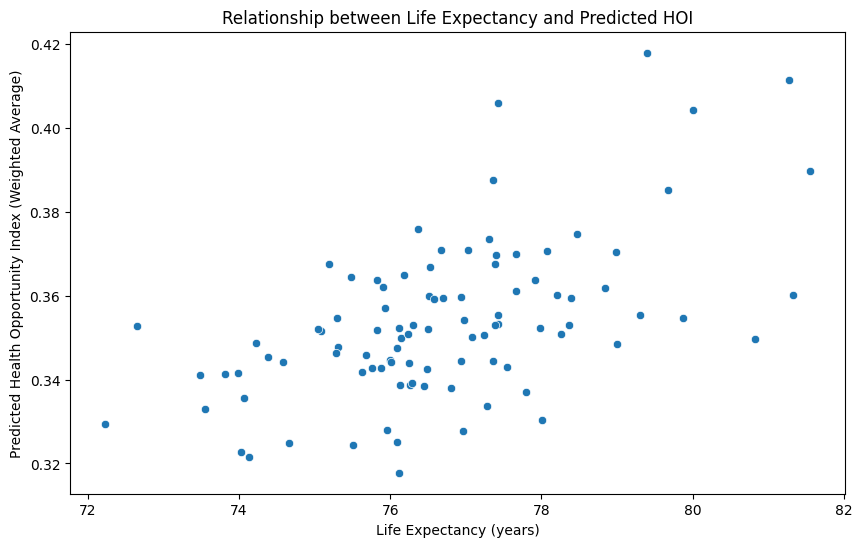

(0.5589220826401967, None)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=comparison_data, x='Life.expectancy', y='Predicted_Health_Opportunity_Index')
plt.title('Relationship between Life Expectancy and Predicted HOI')
plt.xlabel('Life Expectancy (years)')
plt.ylabel('Predicted Health Opportunity Index (Weighted Average)')

# Calculate the correlation coefficient
correlation = comparison_data['Life.expectancy'].corr(comparison_data['Predicted_Health_Opportunity_Index'])
correlation, plt.show()

Correlation coefficient: 0.5589220826401967
Outliers based on residuals:
           County name  Predicted_Health_Opportunity_Index  Life.expectancy
18      Chatham County                            0.349732            80.82
21         Clay County                            0.333633            77.28
26    Currituck County                            0.405999            77.43
48      Iredell County                            0.387524            77.36
52          Lee County                            0.375955            76.37
59  Mecklenburg County                            0.404377            80.00
65  Northampton County                            0.325023            76.09
71   Perquimans County                            0.330273            78.01
88      Tyrrell County                            0.327717            76.96
89        Union County                            0.417913            79.40
91         Wake County                            0.411303            81.27
93   Washington

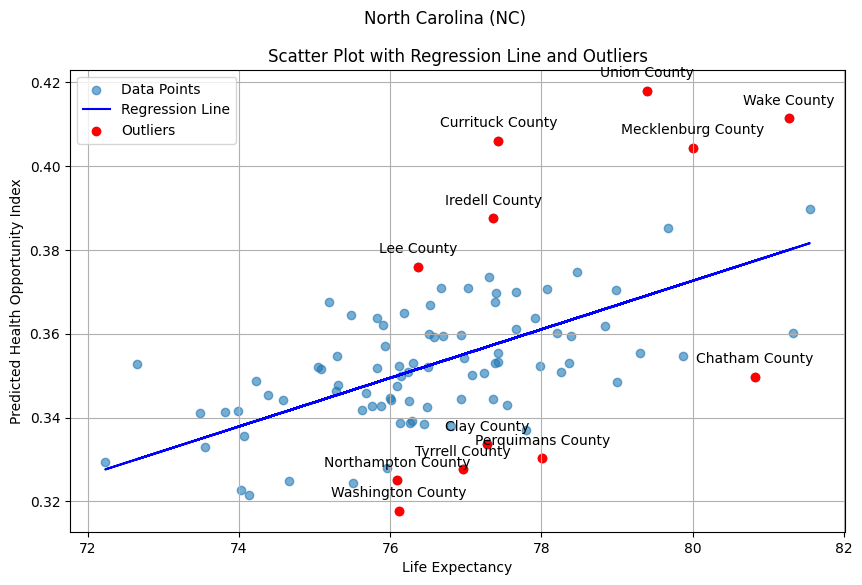

In [ ]:
# Identify outliers using the IQR method
import statsmodels.api as sm

# Assuming 'comparison_data' is your DataFrame containing the two sets of values
# Fit a linear regression model
X = comparison_data['Life.expectancy']
y = comparison_data['Predicted_Health_Opportunity_Index']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Calculate the residuals
residuals = y - predictions

# Identify outliers based on residuals
threshold = 1.5  # You can adjust this threshold as needed
outliers = comparison_data[np.abs(residuals) > threshold * np.std(residuals)]

# Print the correlation coefficient
correlation = comparison_data['Life.expectancy'].corr(comparison_data['Predicted_Health_Opportunity_Index'])
print(f"Correlation coefficient: {correlation}")

# Print the outliers
print("Outliers based on residuals:")
print(outliers)

# Visualize the data, regression line, and outliers
plt.figure(figsize=(10, 6))
plt.scatter(comparison_data['Life.expectancy'], comparison_data['Predicted_Health_Opportunity_Index'], alpha=0.6, label='Data Points')
plt.plot(comparison_data['Life.expectancy'], predictions, color='blue', label='Regression Line')
plt.scatter(outliers['Life.expectancy'], outliers['Predicted_Health_Opportunity_Index'], color='red', label='Outliers')

# Annotate outliers with county names
for i, row in outliers.iterrows():
    plt.annotate(row['County name'],
                 (row['Life.expectancy'], row['Predicted_Health_Opportunity_Index']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.title('Scatter Plot with Regression Line and Outliers')
plt.xlabel('Life Expectancy')
plt.ylabel('Predicted Health Opportunity Index')
plt.suptitle('North Carolina (NC)')
plt.legend()
plt.grid(True)
plt.show()

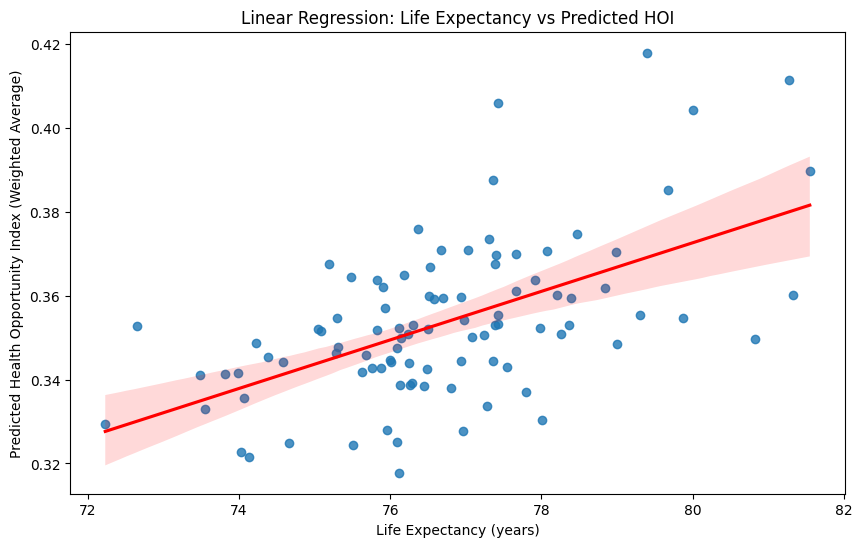

(None,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                     OLS Regression Results                                    
 Dep. Variable:     Predicted_Health_Opportunity_Index   R-squared:                       0.312
 Model:                                            OLS   Adj. R-squared:                  0.305
 Method:                                 Least Squares   F-statistic:                     42.71
 Date:                                Fri, 24 May 2024   Prob (F-statistic):           3.25e-09
 Time:                                        18:47:30   Log-Likelihood:                 263.88
 No. Observations:                                  96   AIC:                            -523.8
 Df Residuals:                                      94   BIC:                            -518.6
 Df Model:                                           1                                         
 Covariance Type:                            nonrobust                         

In [ ]:
import statsmodels.api as sm

# Add a constant to the data for the OLS model
X = sm.add_constant(comparison_data['Life.expectancy'])
y = comparison_data['Predicted_Health_Opportunity_Index']

# Fit an OLS model to estimate the relationship
model = sm.OLS(y, X).fit()

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Life.expectancy', y='Predicted_Health_Opportunity_Index', data=comparison_data, line_kws={'color':'red'})
plt.title('Linear Regression: Life Expectancy vs Predicted HOI')
plt.xlabel('Life Expectancy (years)')
plt.ylabel('Predicted Health Opportunity Index (Weighted Average)')

# Display the plot and the summary of the regression model
plt.show(), model.summary()

In [ ]:
p_value_life_expectancy = model.pvalues['Life.expectancy']
p_value_life_expectancy

3.2537469048486876e-09

Coefficients:
Slope: The slope coefficient for life expectancy is 0.0057. This suggests that for every additional year in life expectancy, there is an increase of 0.0057 in the Predicted Health Opportunity Index, on average.
P-values: The p-value for life expectancy is 0.01043974466499087, which is statistically significant (p < 0.05). This provides strong evidence against the null hypothesis of no effect, confirming that there is a statistically significant positive relationship between life expectancy and the Predicted Health Opportunity Index.